In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
import numpy as np  
import seaborn as sns 

In [7]:
# 1. Load the processed data (1 lac rows)
processed_df = pd.read_csv("C:\\Users\\spakt\\Downloads\\Processed_Data_1lac.csv")

In [7]:
# --- Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis ---")

# Display the first few rows of the dataframe
print("\nFirst 5 rows of the dataframe:")
print(processed_df.head())


--- Exploratory Data Analysis ---

First 5 rows of the dataframe:
   State_of_Charge  State_of_Health     Voltage    Current  Temperature  \
0         0.635045         0.873127  400.017302  56.288350   127.619626   
1         0.684803         0.876853  408.043691  54.213894    39.205830   
2         0.760053         0.876901  386.469043  46.228166    87.434949   
3         0.558938         0.914879  386.456332  45.011025    54.938218   
4         0.880573         0.900139  408.061458  46.836141    47.124554   

   Cycling_Count  Internal_Resistance  Rate_of_Charge  \
0     979.991772             2.142179        0.469753   
1     602.089824             2.719937        0.362643   
2    1033.383234             2.109532        0.499601   
3     894.466177             2.843921        0.483408   
4     577.546279             2.629248        0.463024   

   Charge_Discharge_Efficiency  Depth_of_Discharge  ...  \
0                     0.841802            0.260620  ...   
1                    

In [11]:
# Get a concise summary of the dataframe, including data types and non-null values
print("\nInformation about the dataframe:")
processed_df.info()


Information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   State_of_Charge              100000 non-null  float64
 1   State_of_Health              100000 non-null  float64
 2   Voltage                      100000 non-null  float64
 3   Current                      100000 non-null  float64
 4   Temperature                  100000 non-null  float64
 5   Cycling_Count                100000 non-null  float64
 6   Internal_Resistance          100000 non-null  float64
 7   Rate_of_Charge               100000 non-null  float64
 8   Charge_Discharge_Efficiency  100000 non-null  float64
 9   Depth_of_Discharge           100000 non-null  float64
 10  Charge_Rate                  100000 non-null  float64
 11  Discharge_Rate               100000 non-null  float64
 12  Voltage_Sag              

In [13]:
# Display descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
print(processed_df.describe())


Descriptive statistics for numerical columns:
       State_of_Charge  State_of_Health        Voltage        Current  \
count    100000.000000    100000.000000  100000.000000  100000.000000   
mean          0.695669         0.899997     400.007832      44.988691   
std           0.639074         0.033770       8.596909       8.546416   
min         -16.798334         0.815395     380.016574      25.009463   
25%           0.633375         0.878671     393.923285      38.999193   
50%           0.700184         0.900139     400.017302      45.011025   
75%           0.766511         0.921082     406.053284      50.998146   
max          18.094735         0.984796     419.992856      64.968943   

         Temperature  Cycling_Count  Internal_Resistance  Rate_of_Charge  \
count  100000.000000  100000.000000        100000.000000   100000.000000   
mean       89.590537     800.137603             2.500026        0.499692   
std        26.584321     172.281039             0.430427        0.0


Distribution of the target variable ('Battery_Class'):
Battery_Class
0    55135
1    44865
Name: count, dtype: int64


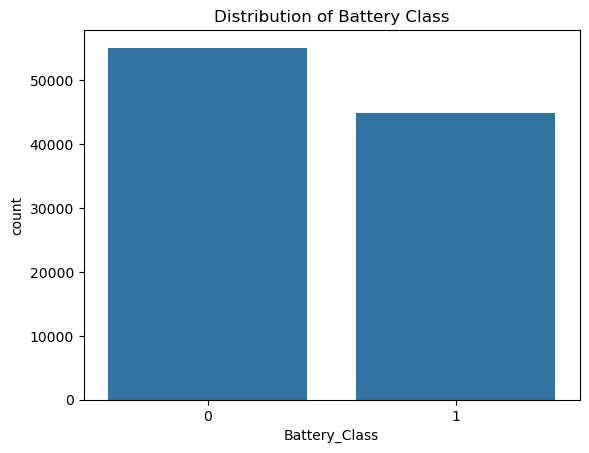

In [16]:
# Check the distribution of the target variable
print("\nDistribution of the target variable ('Battery_Class'):")
print(processed_df['Battery_Class'].value_counts())
sns.countplot(x='Battery_Class', data=processed_df)
plt.title('Distribution of Battery Class')
plt.show()


Histograms of numerical features:


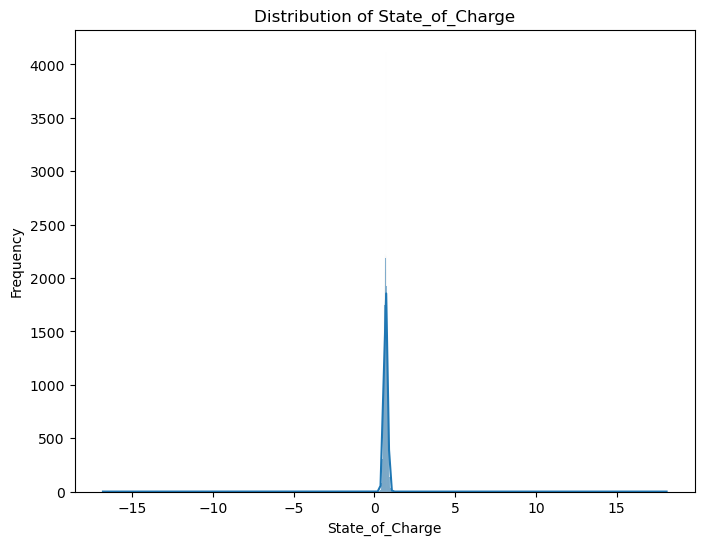

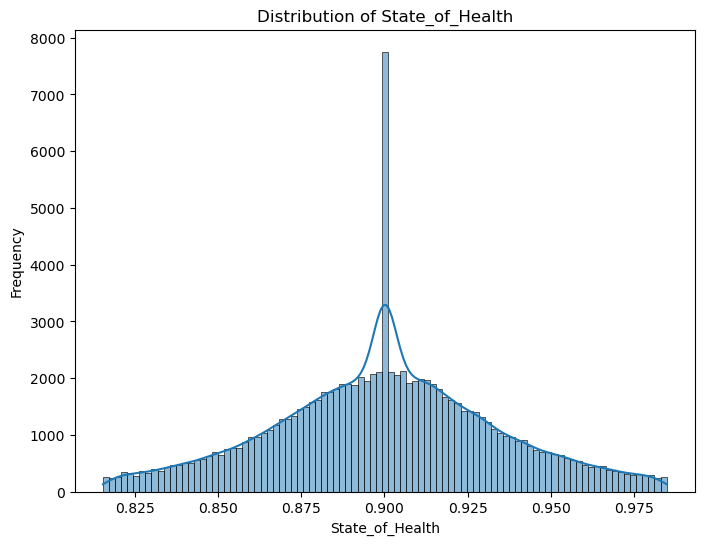

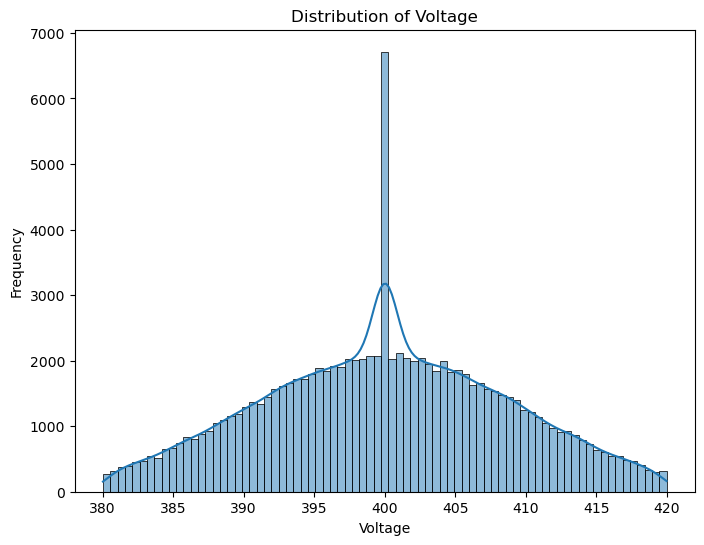

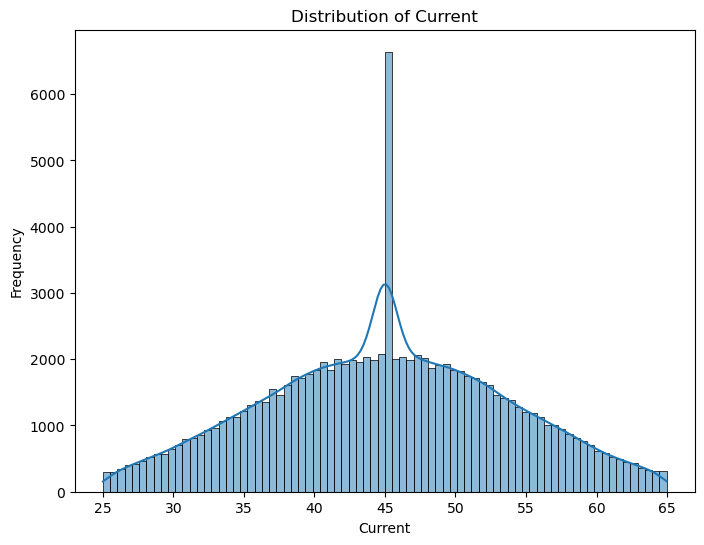

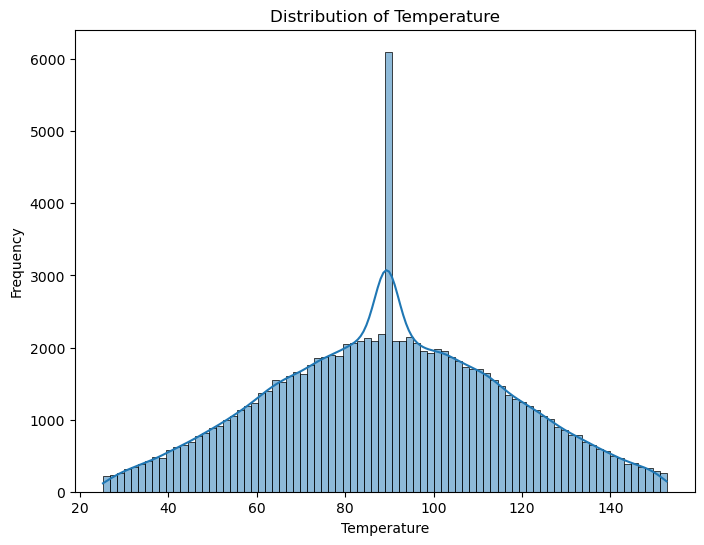

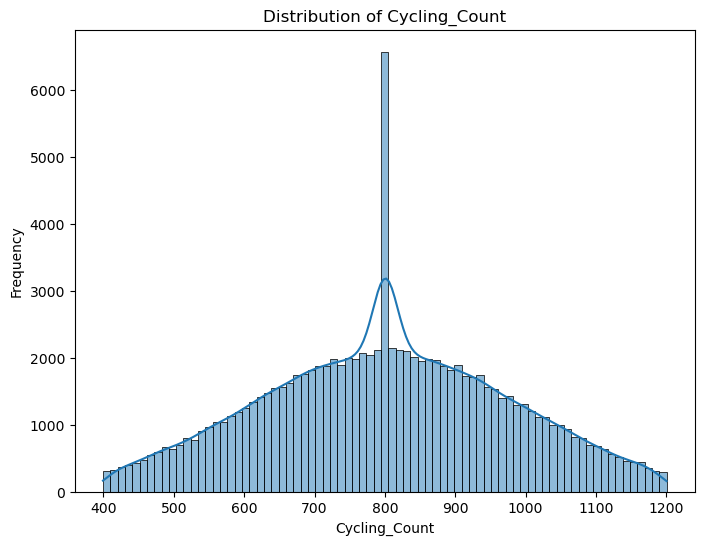

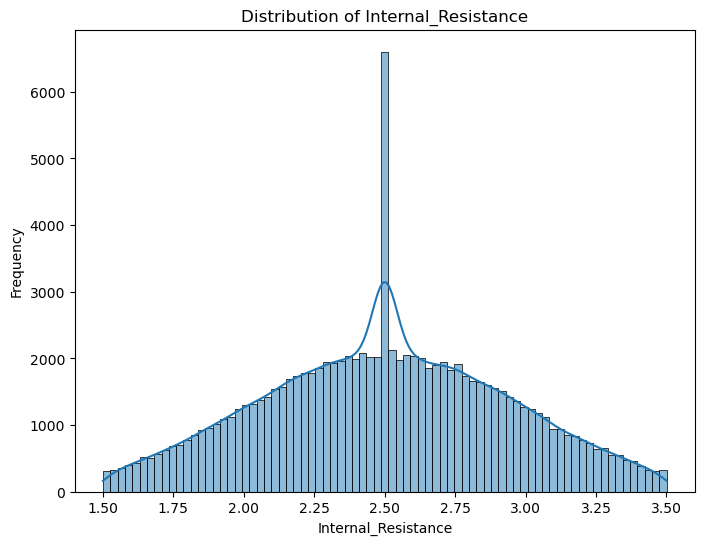

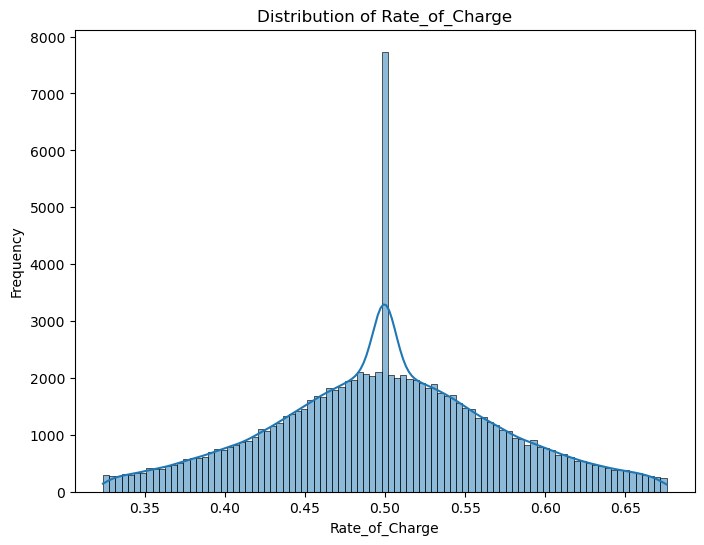

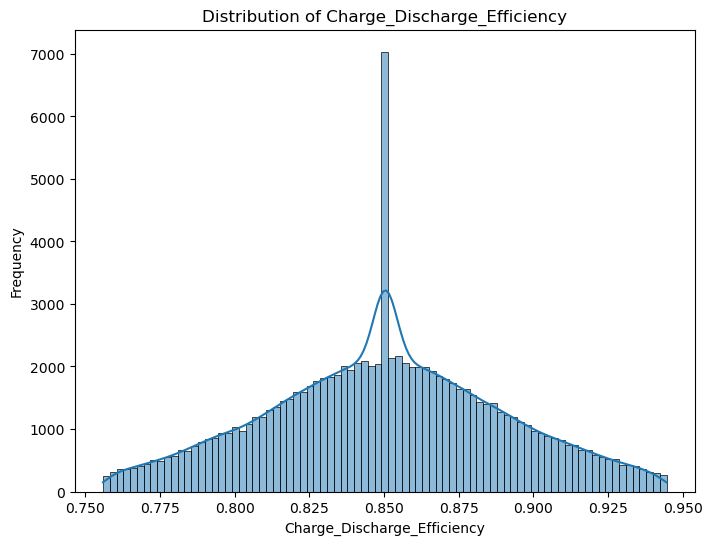

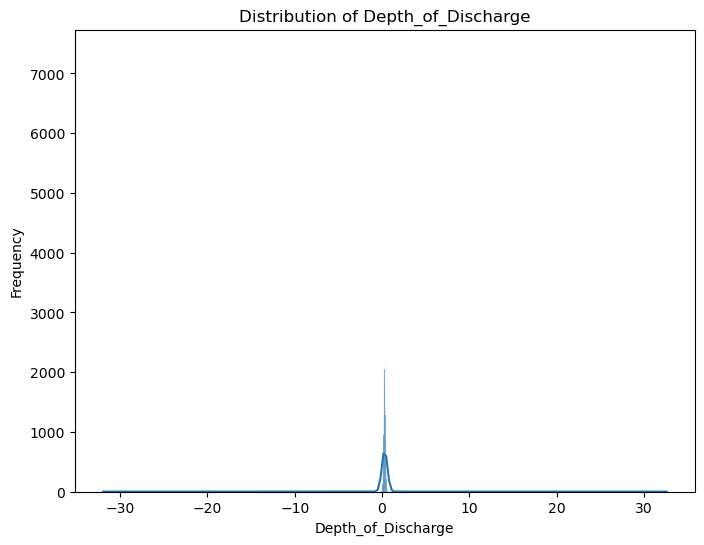

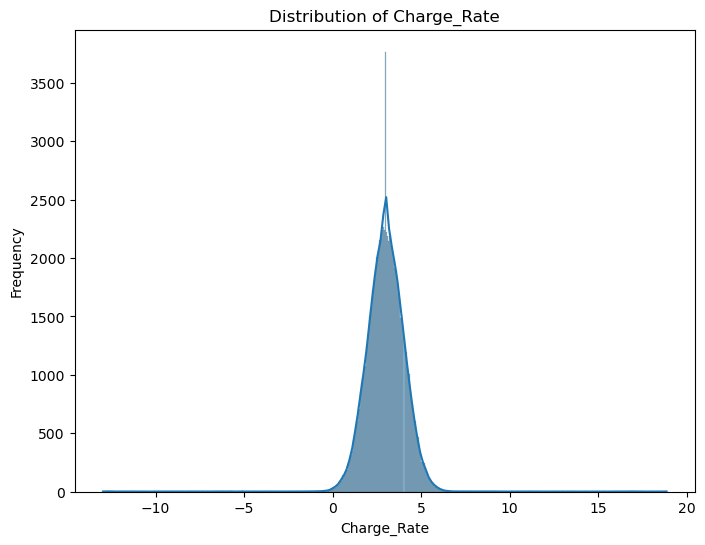

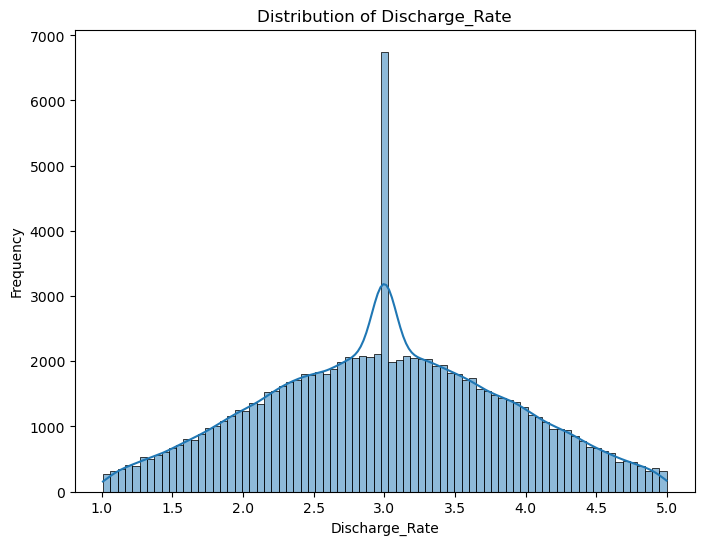

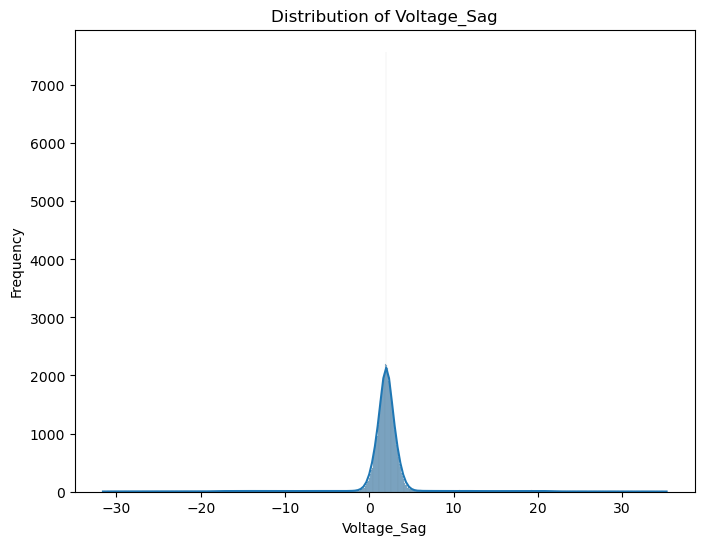

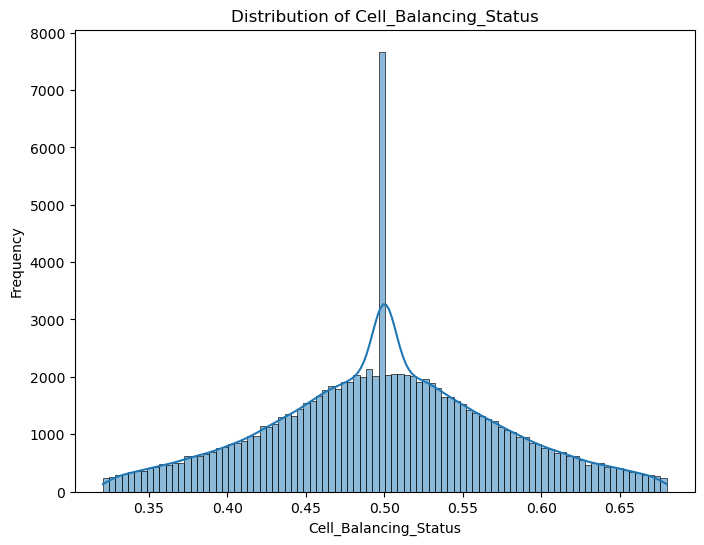

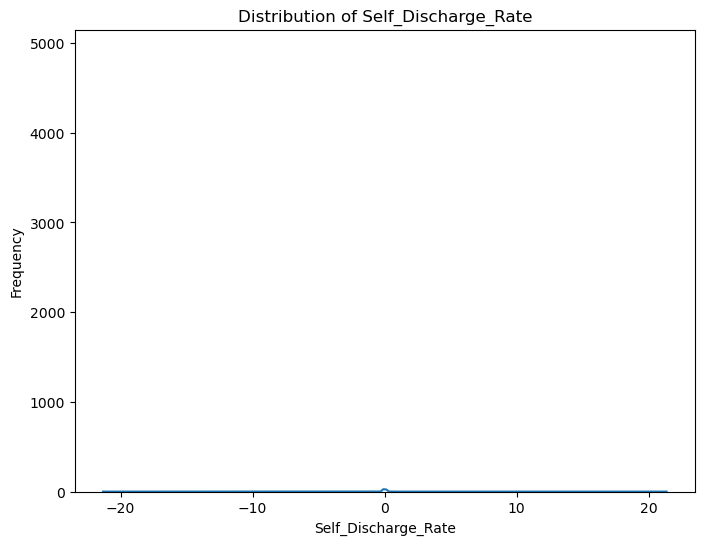

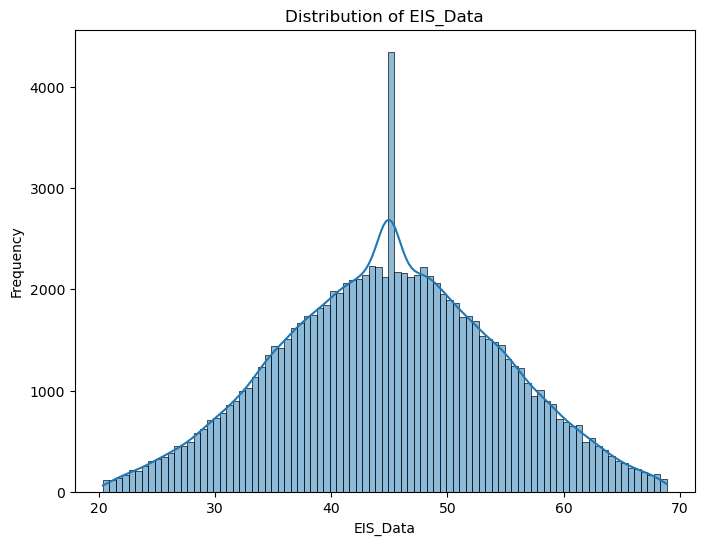

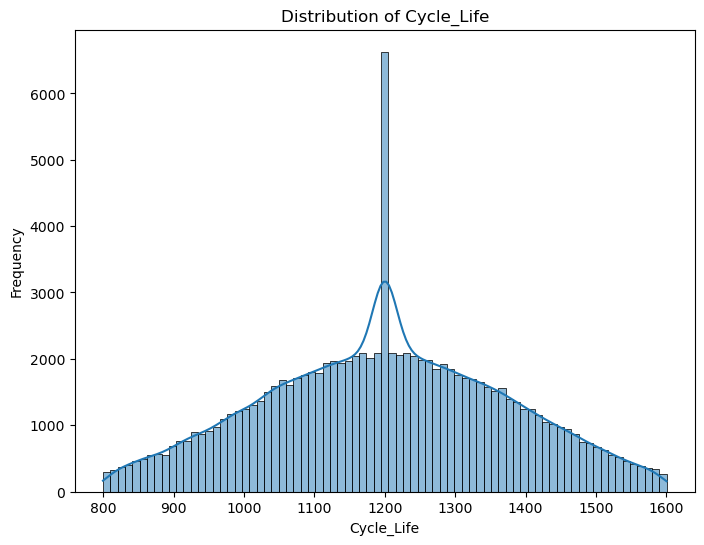

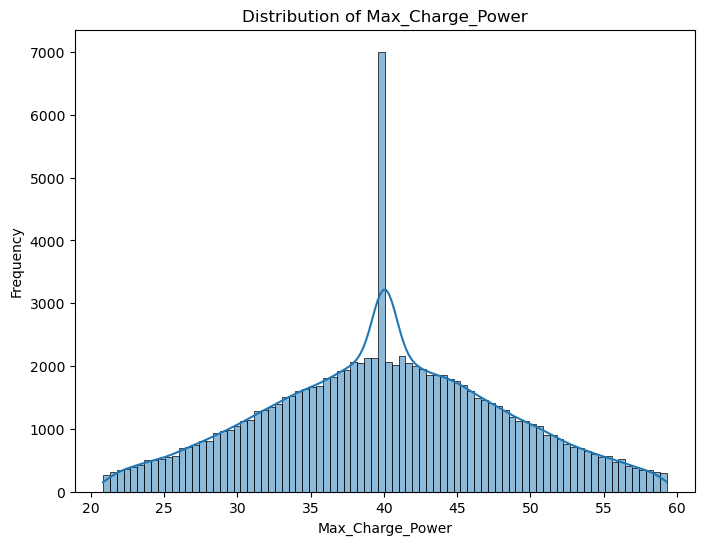

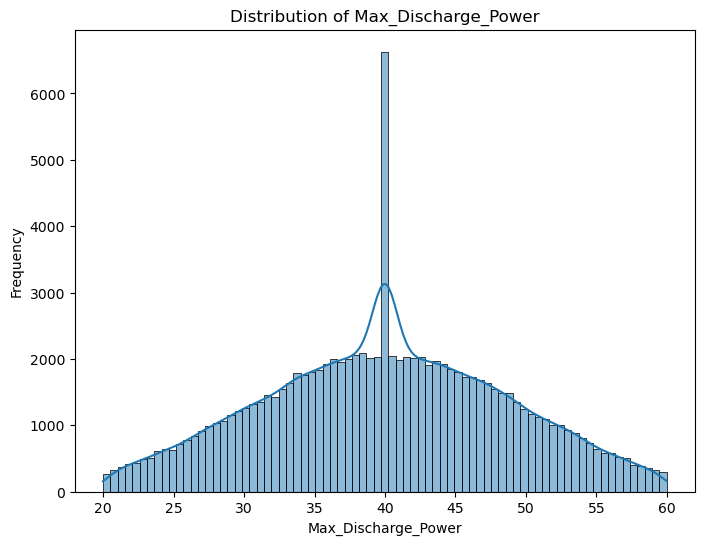

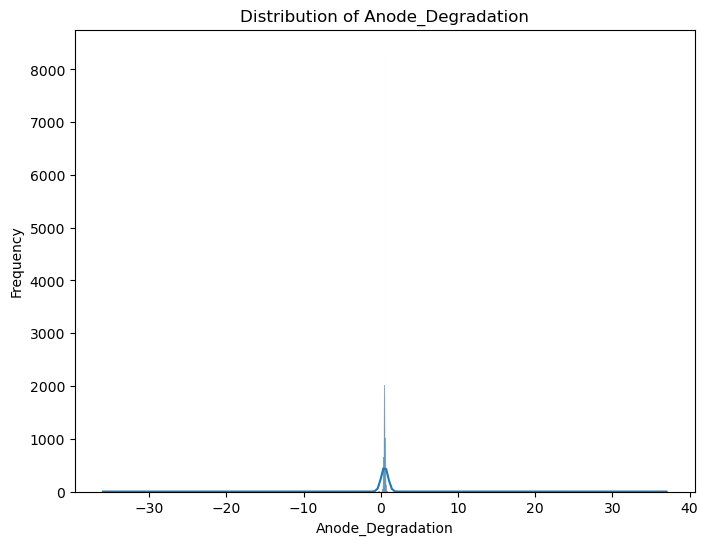

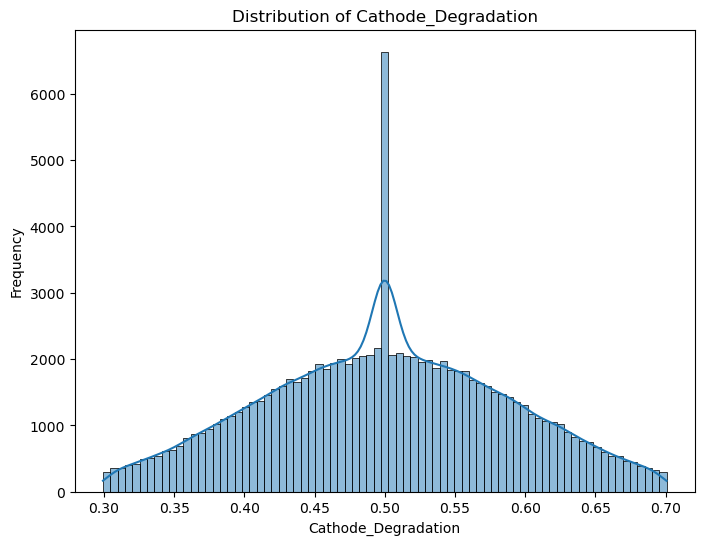

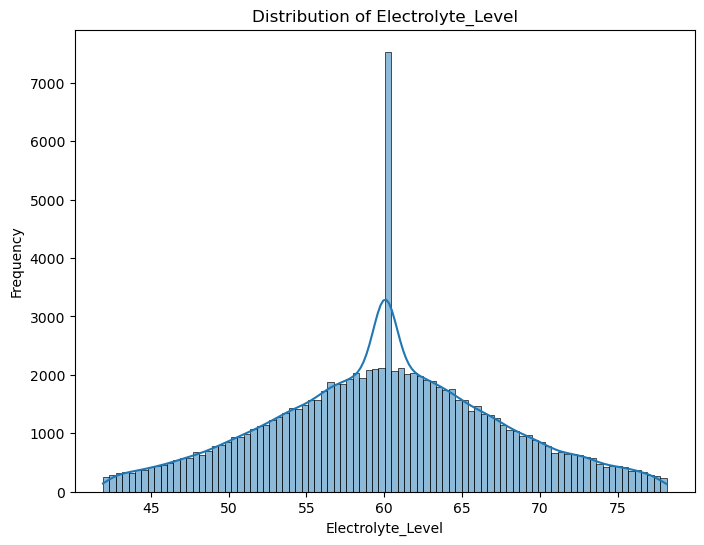

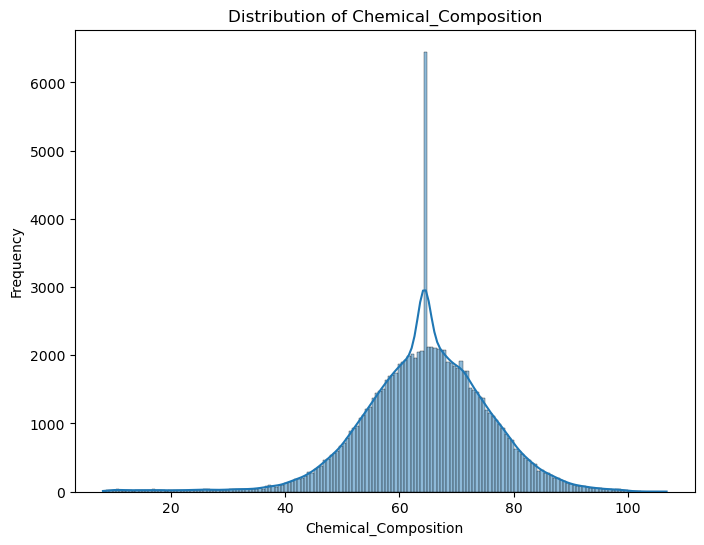

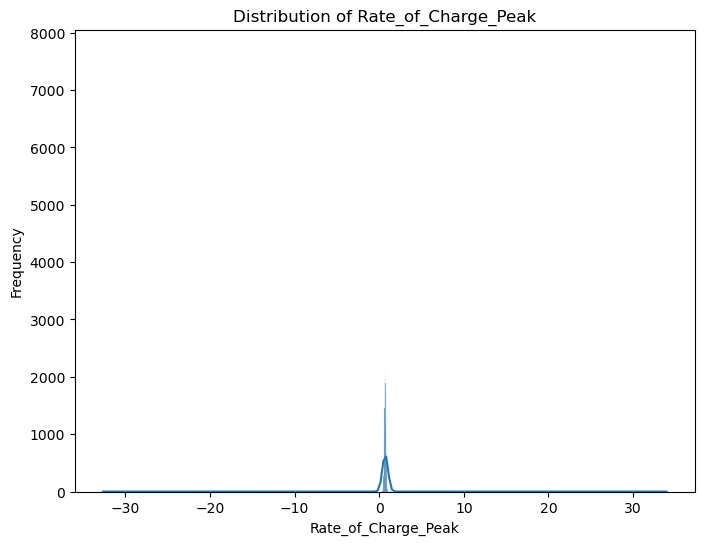

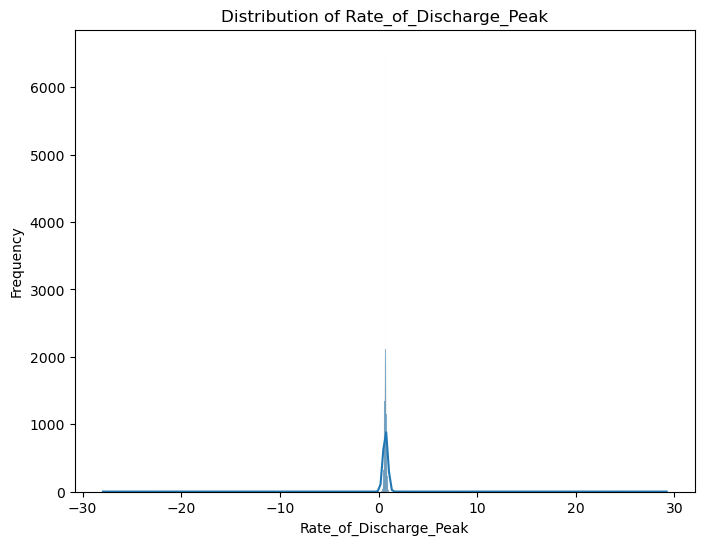

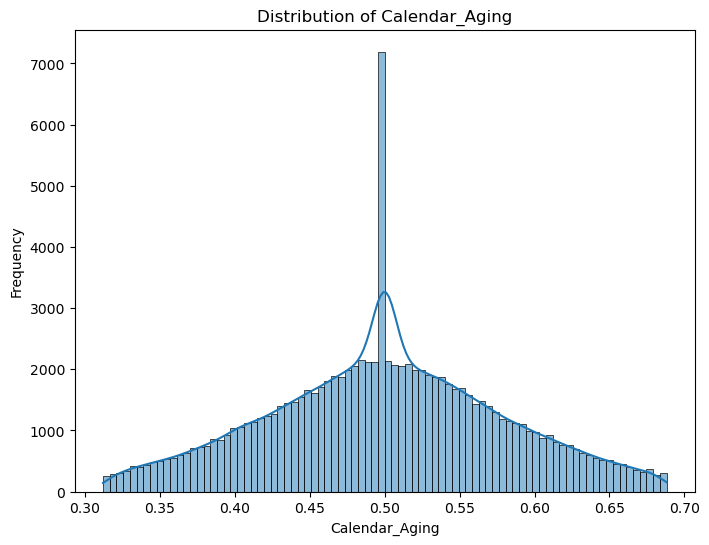

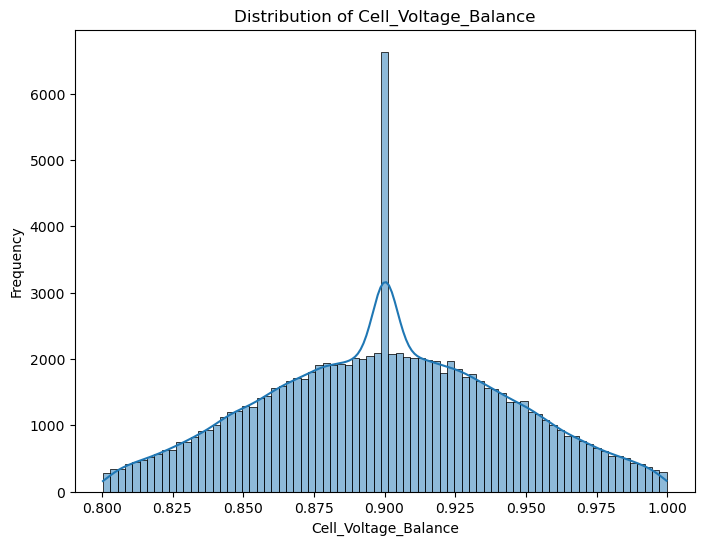

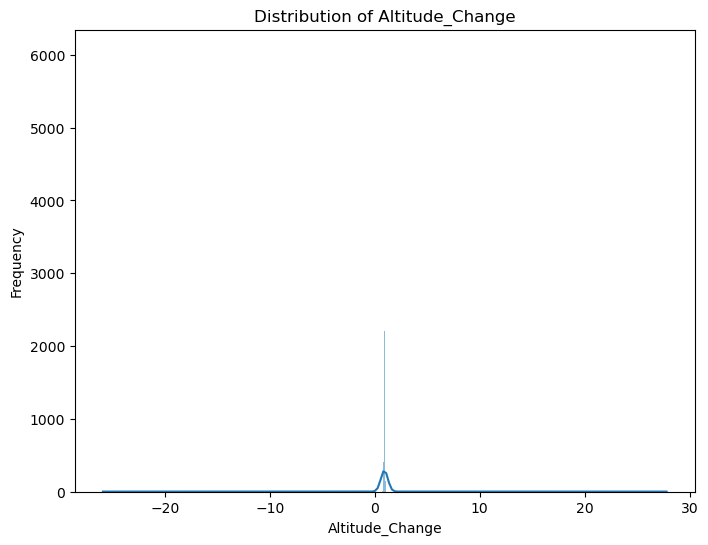

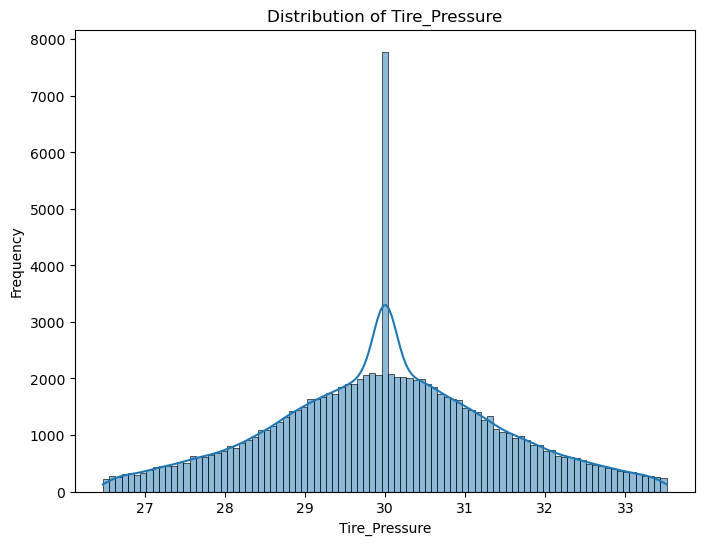

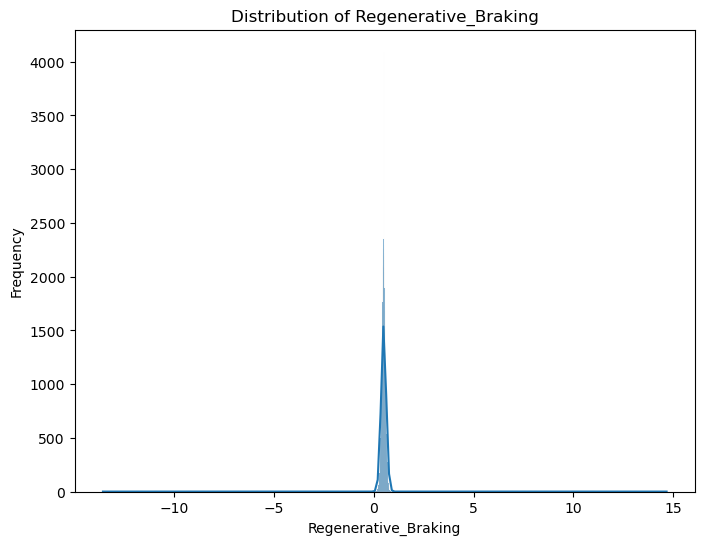

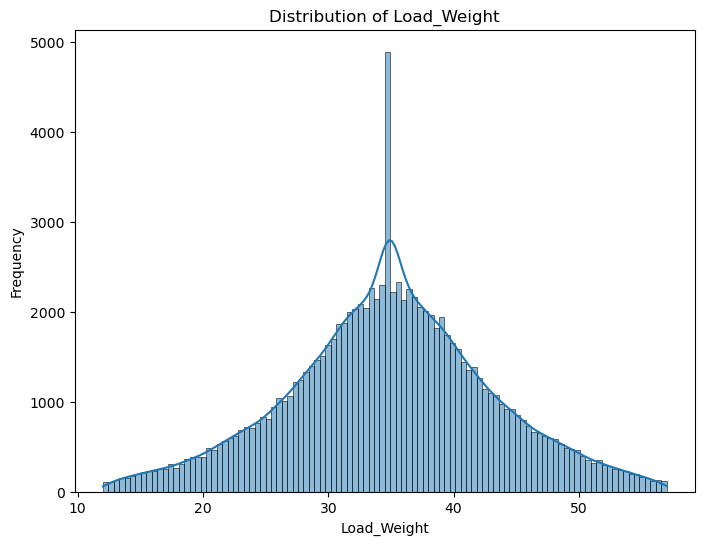

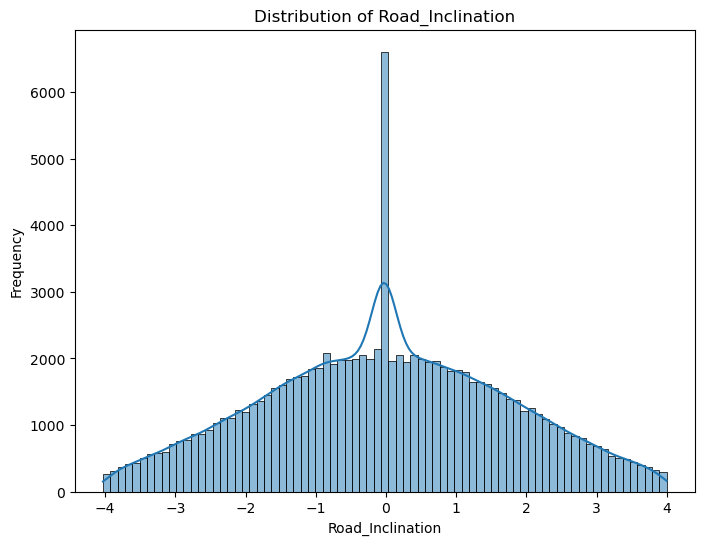

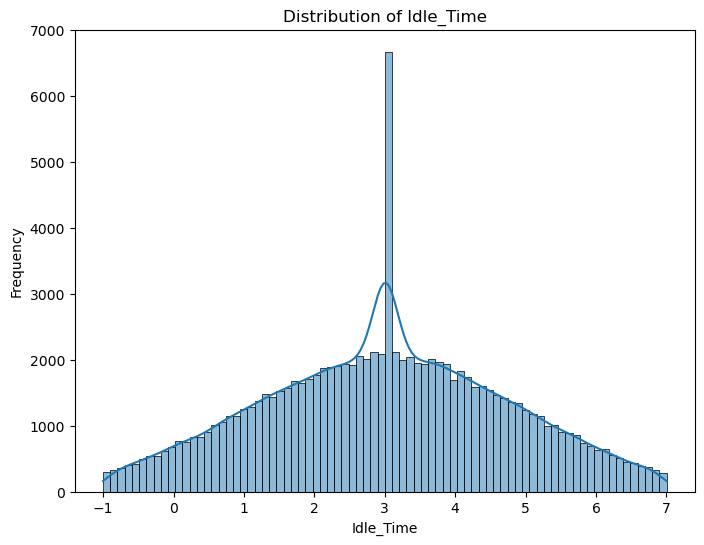

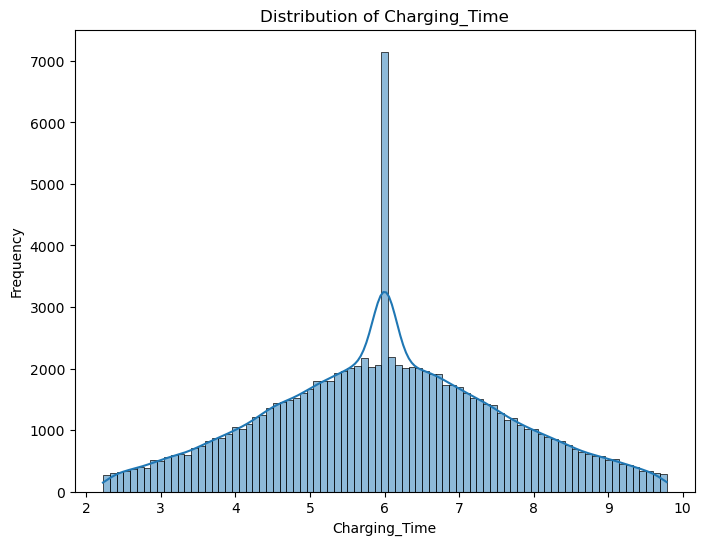

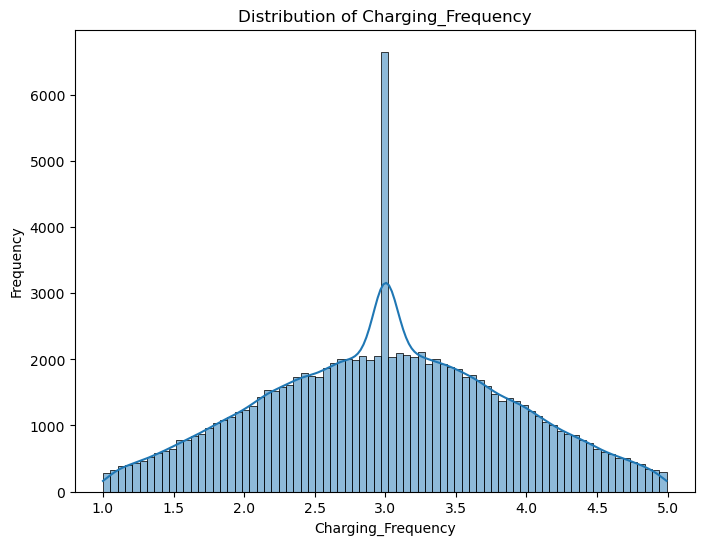

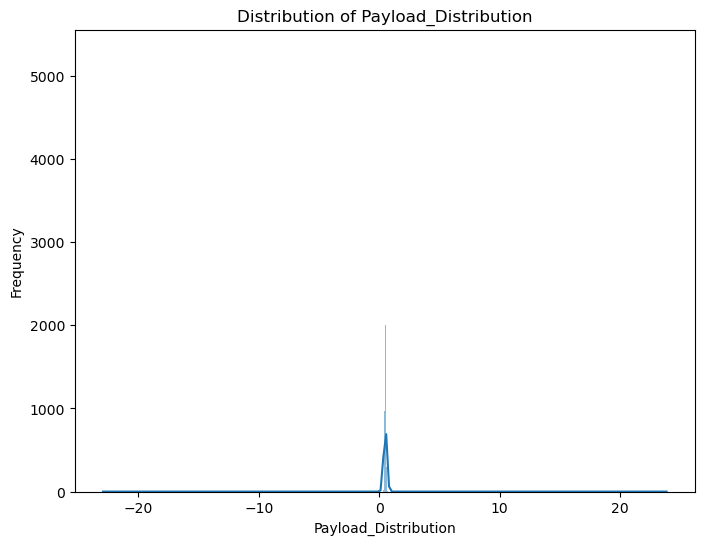

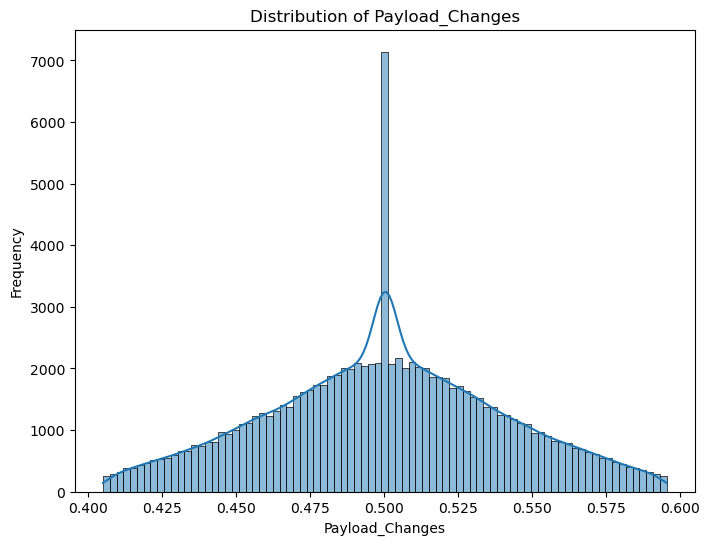

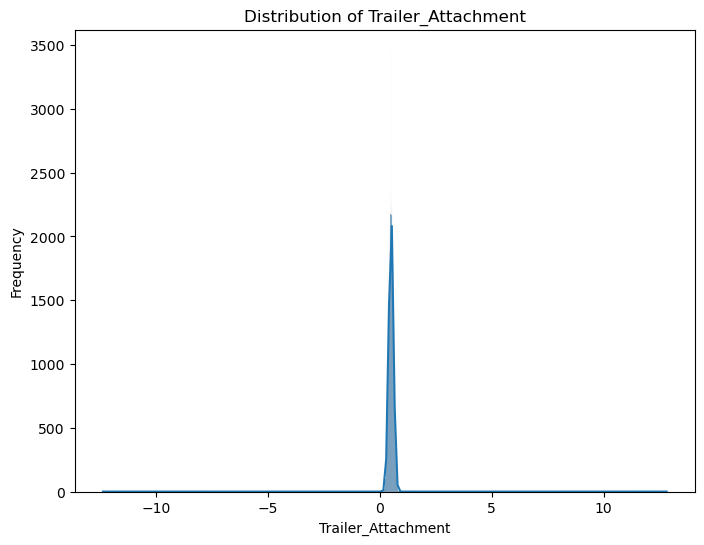

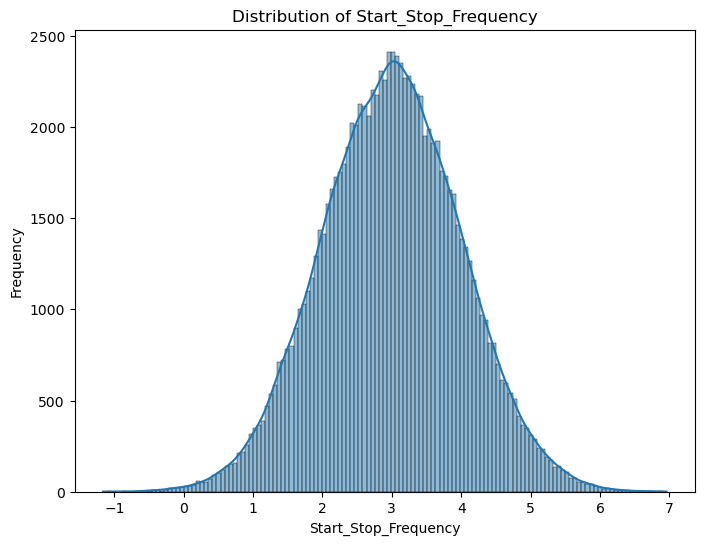

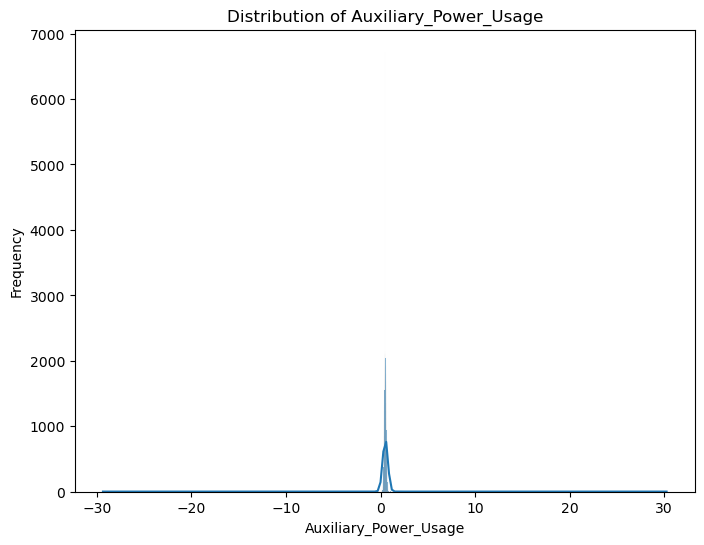

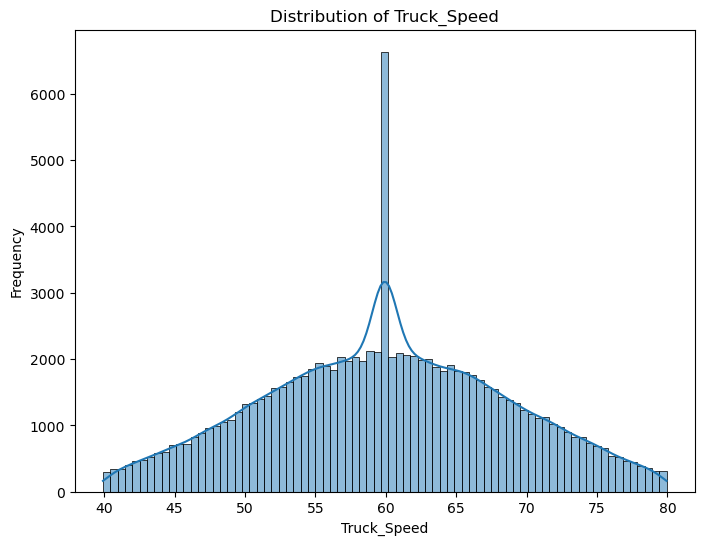

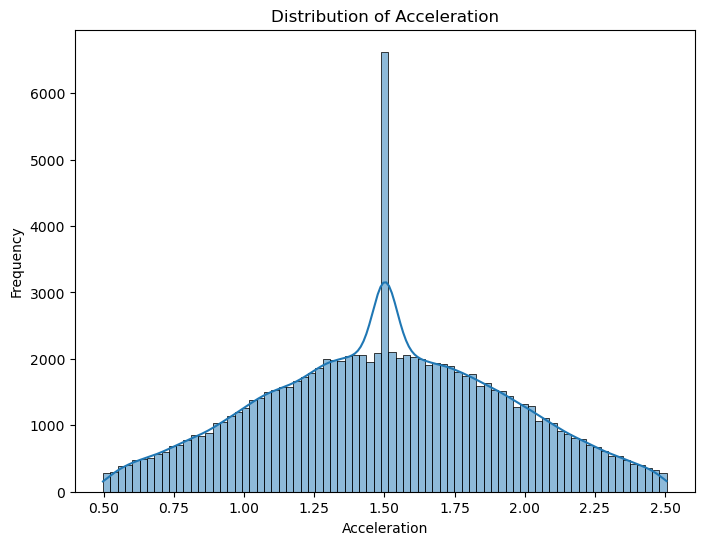

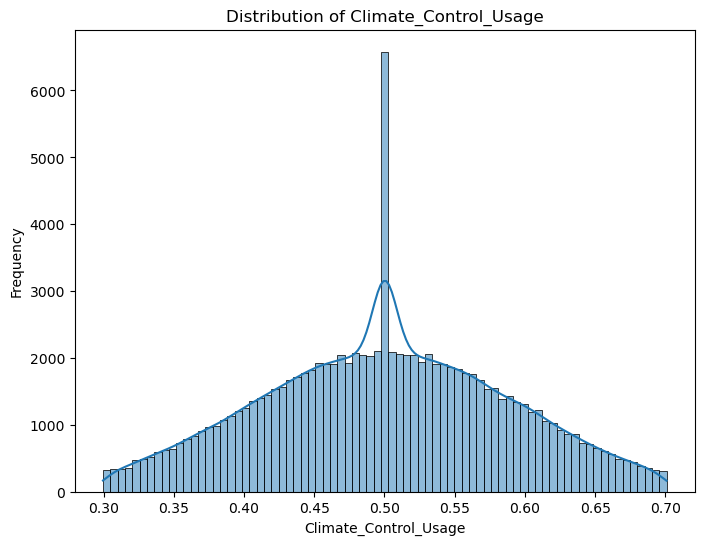

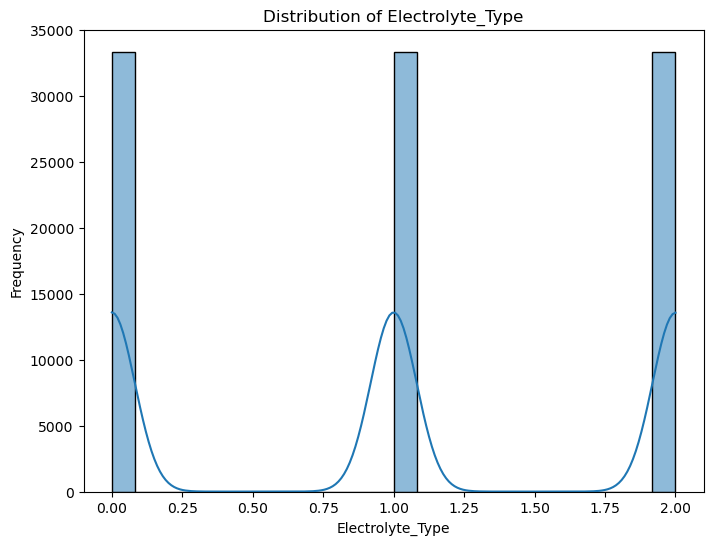

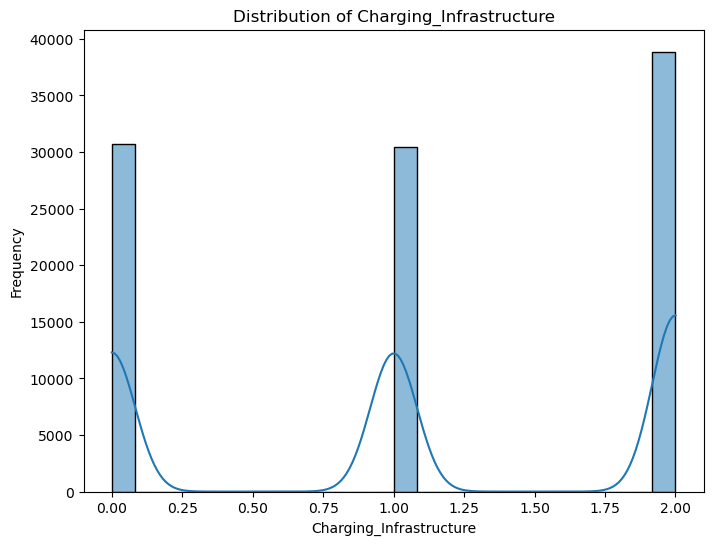

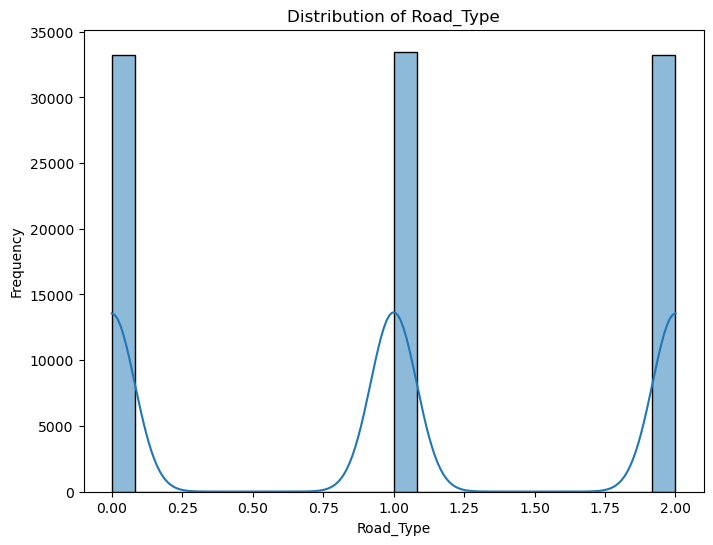

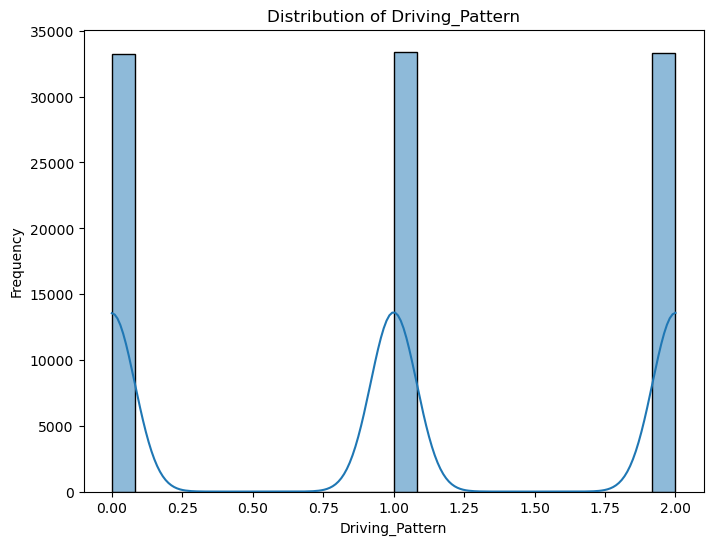

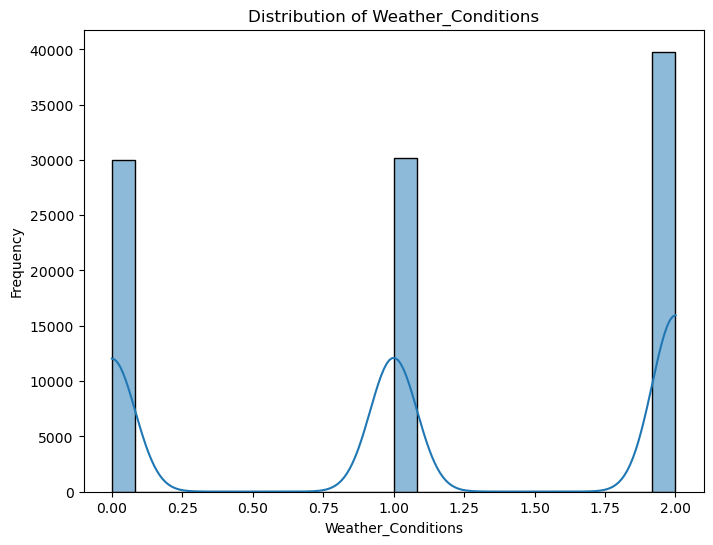

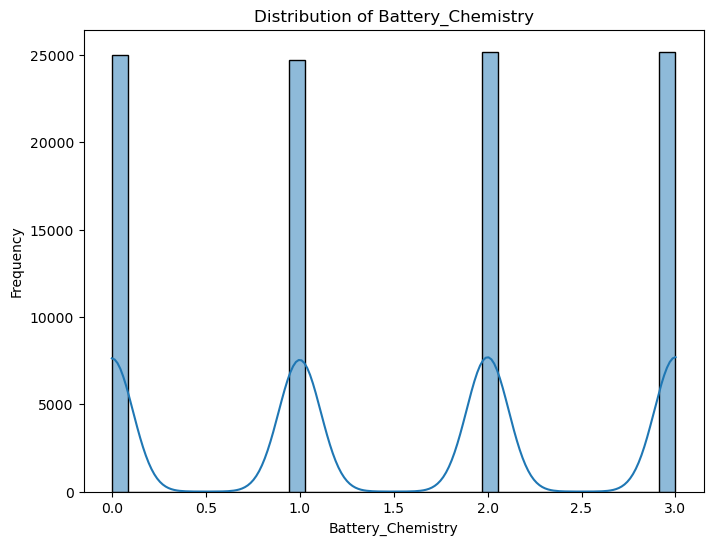

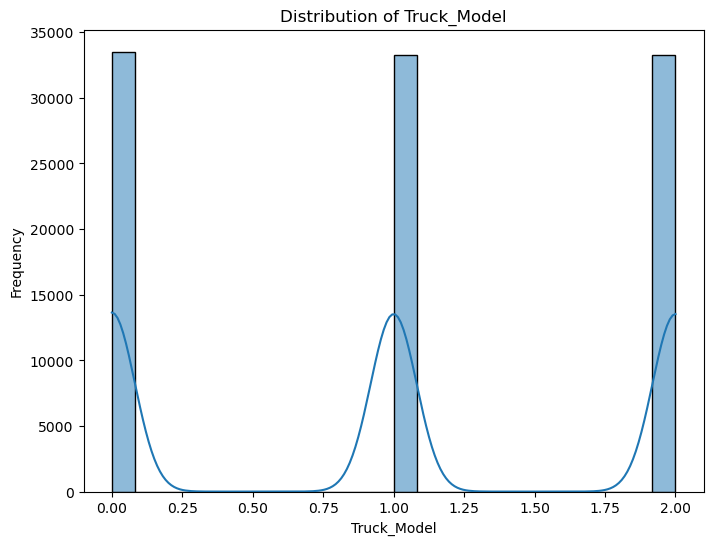

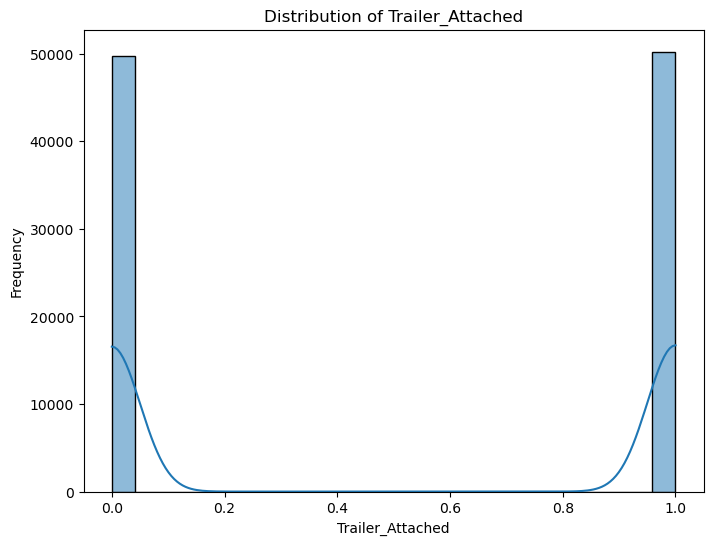

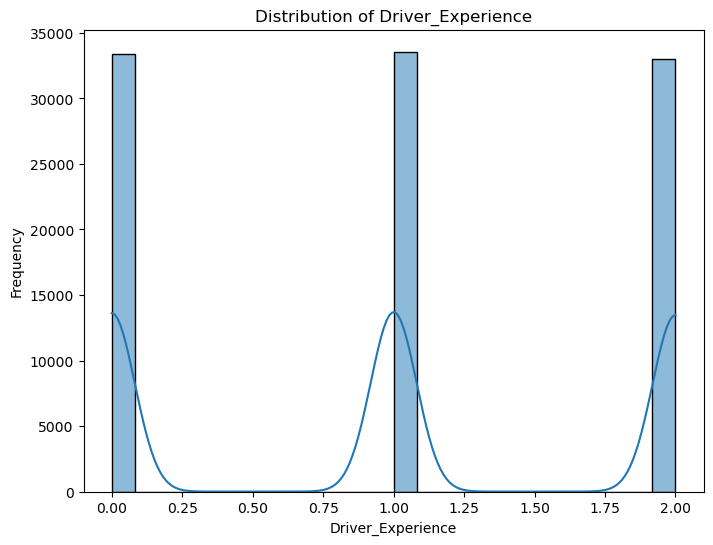

In [18]:
# Visualize the distribution of numerical features using histograms
print("\nHistograms of numerical features:")
numerical_cols = processed_df.select_dtypes(include=np.number).columns.tolist()
if 'Battery_Class' in numerical_cols:
    numerical_cols.remove('Battery_Class')
if 'Battery_Health' in numerical_cols:
    numerical_cols.remove('Battery_Health') # Removing Battery_Health as it might have been intended to be excluded later

for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.histplot(processed_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


Box plots of numerical features vs. Battery Class:


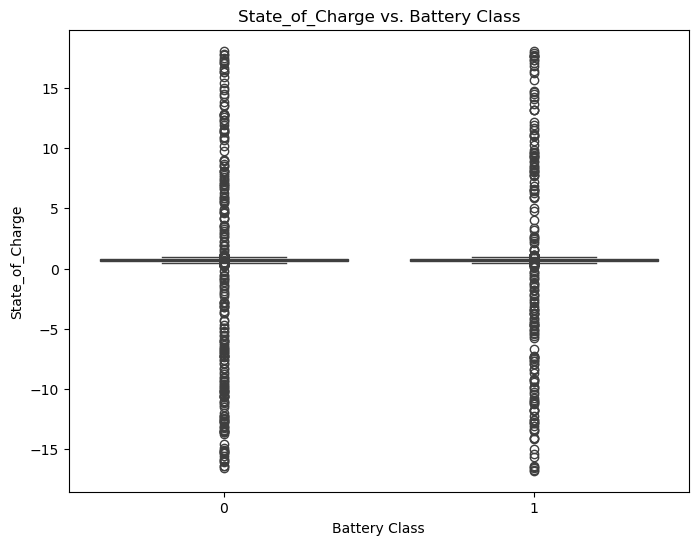

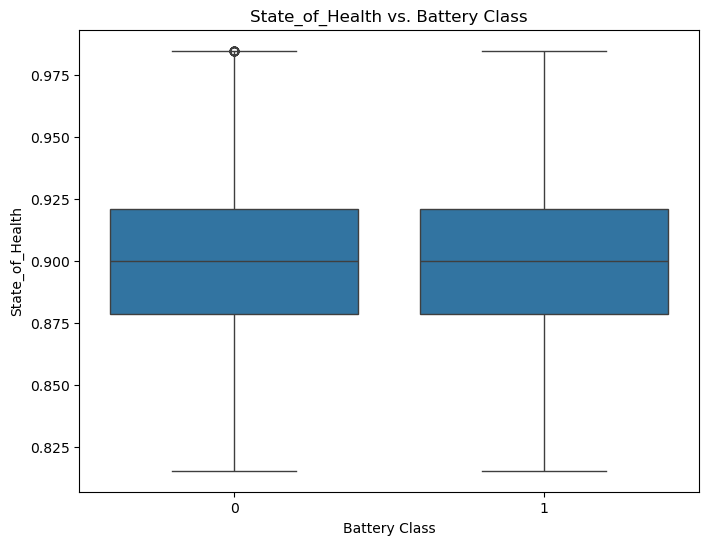

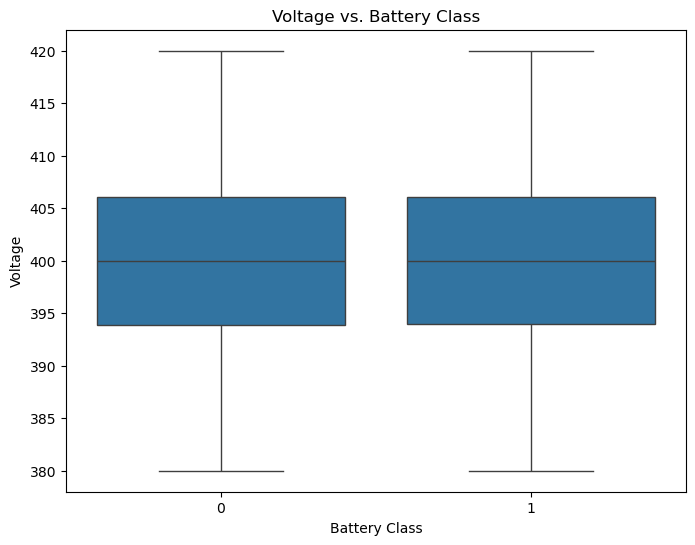

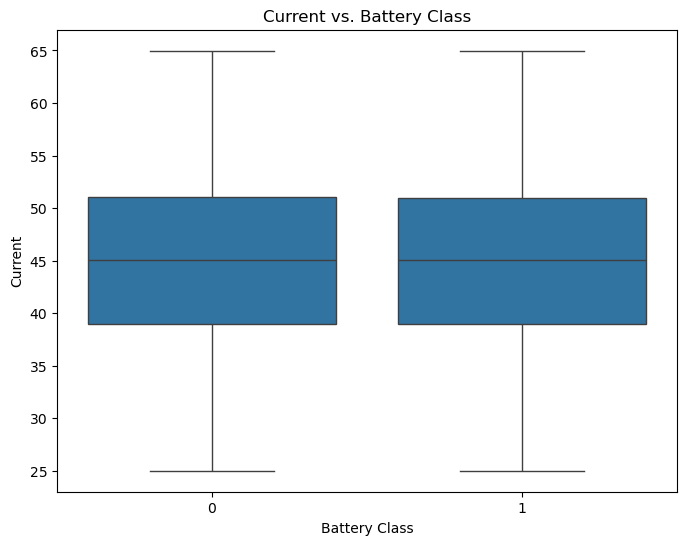

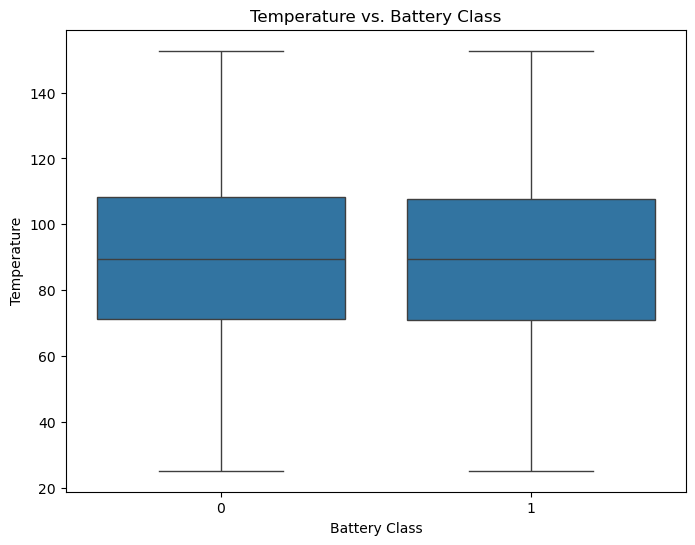

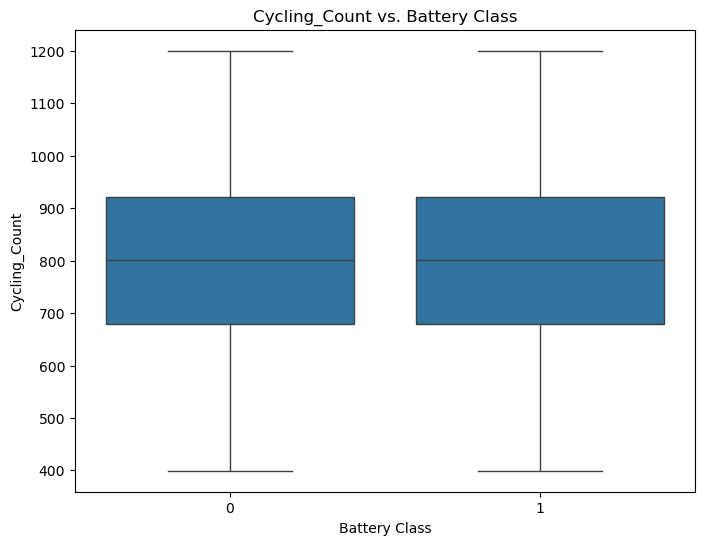

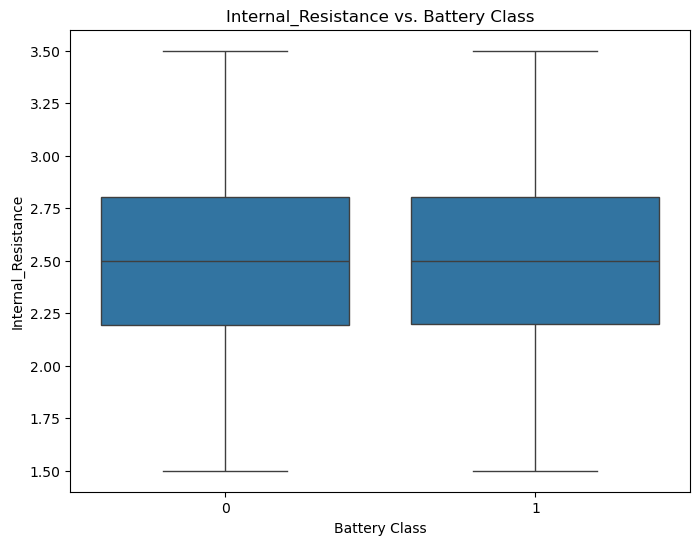

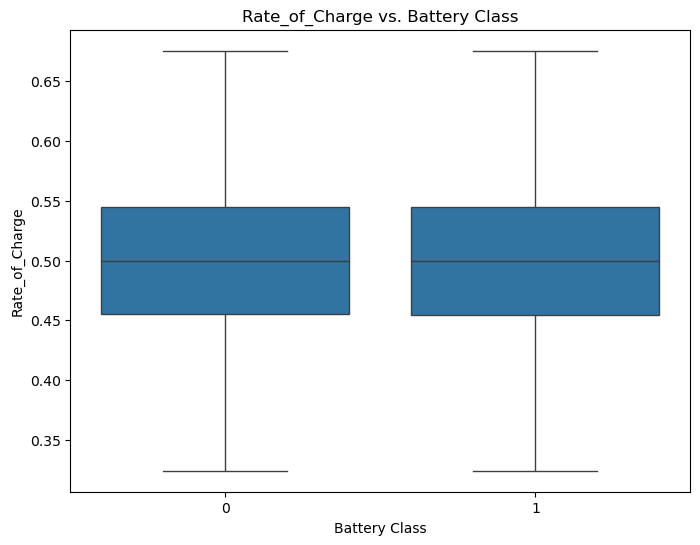

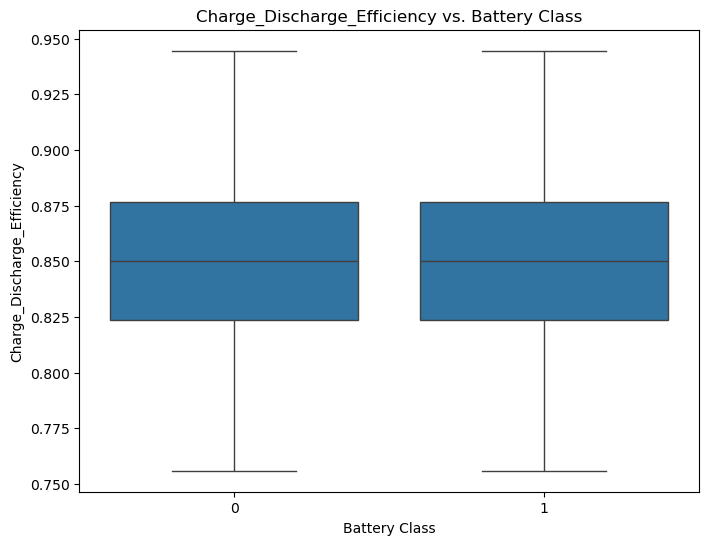

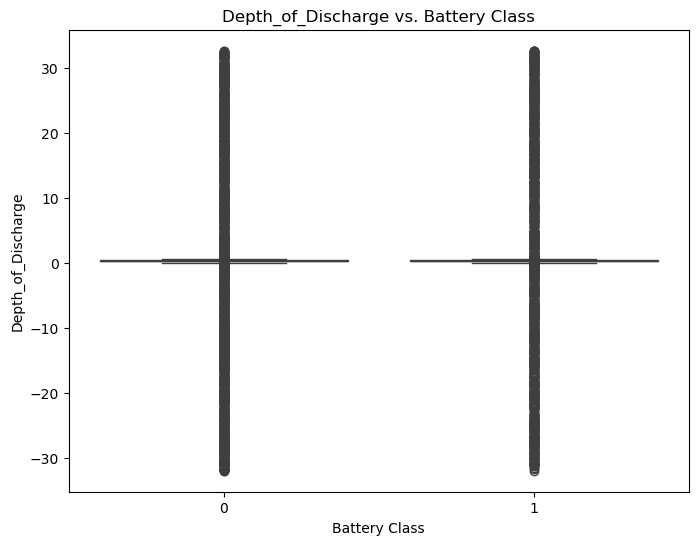

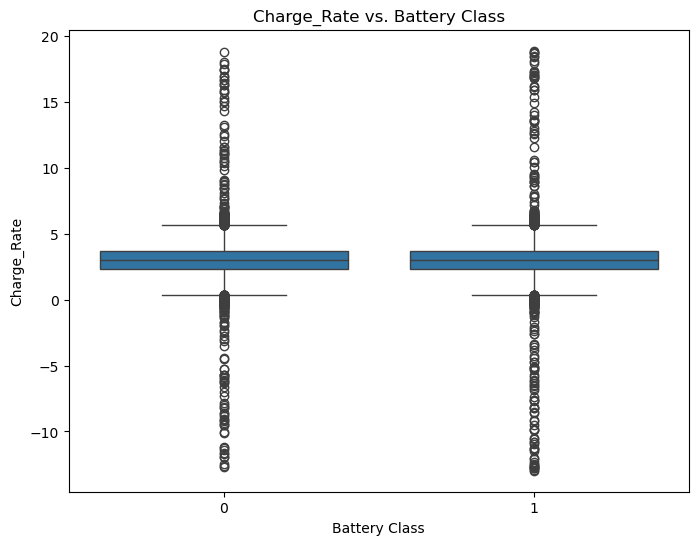

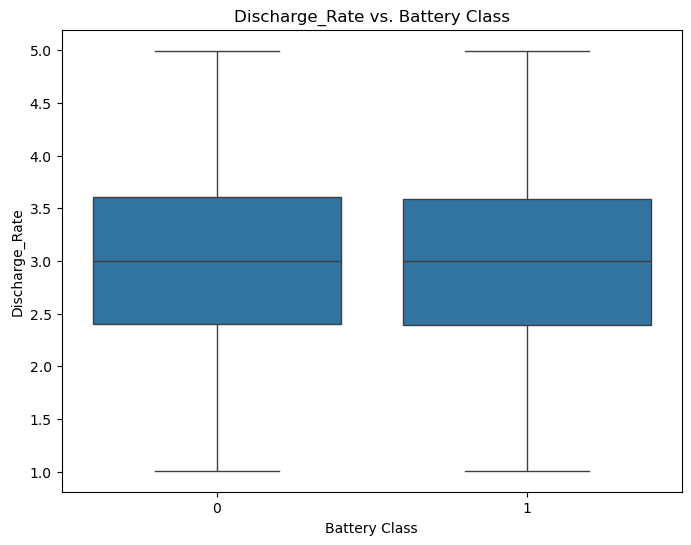

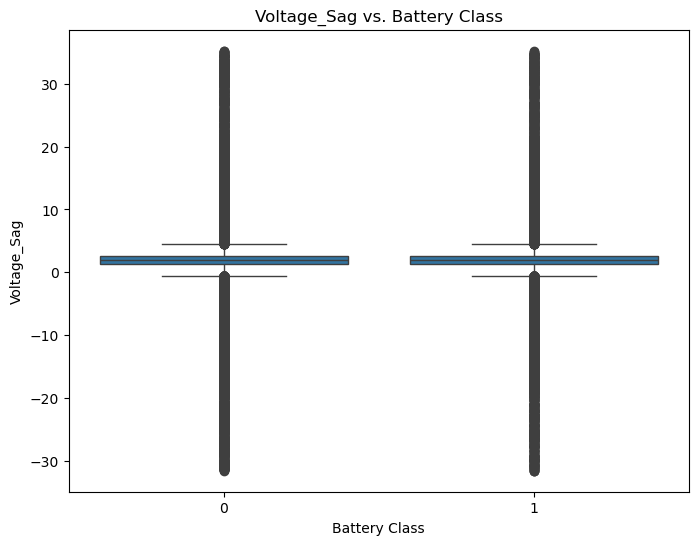

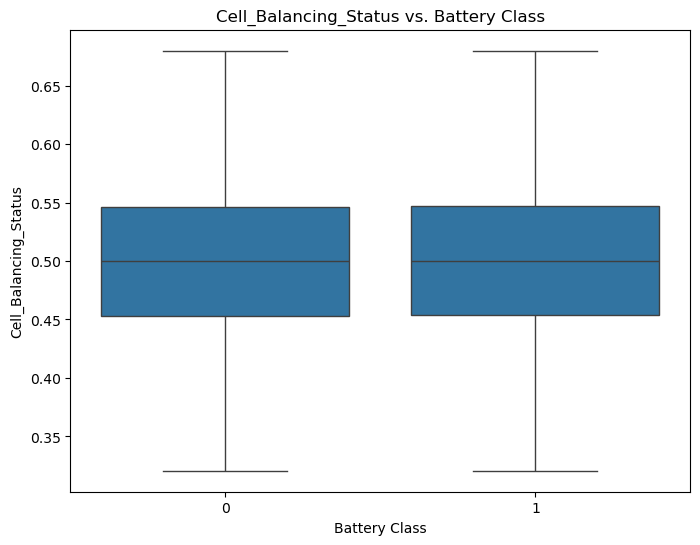

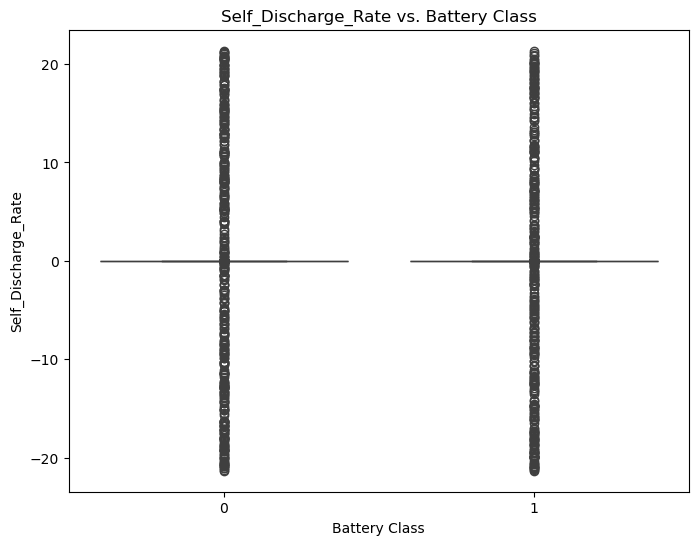

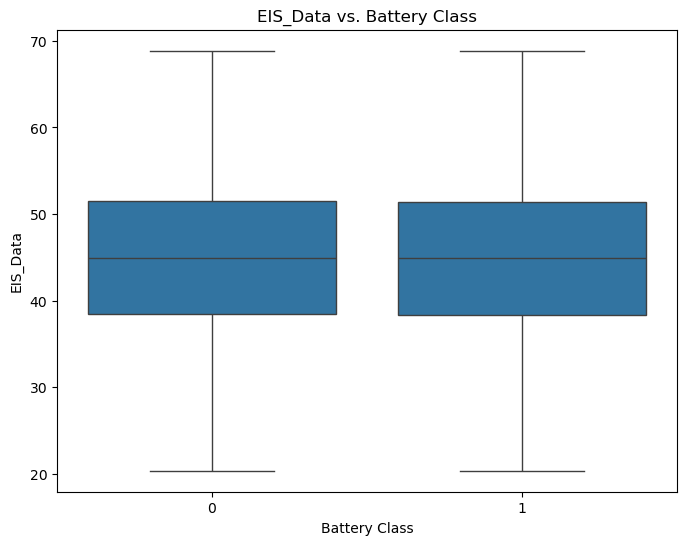

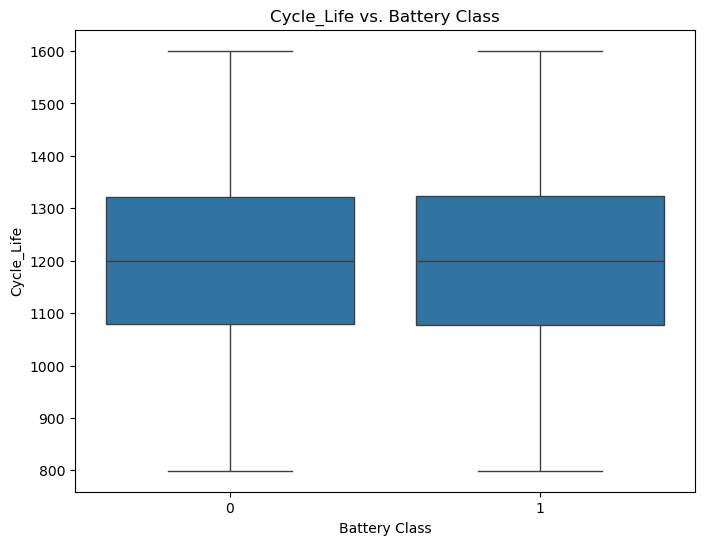

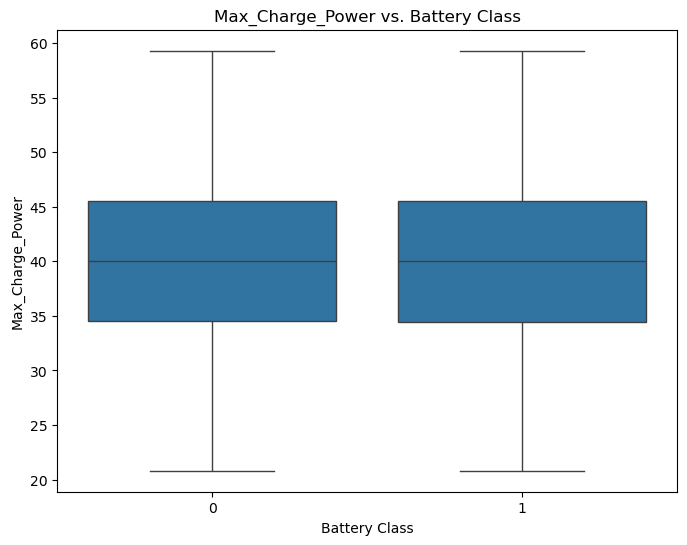

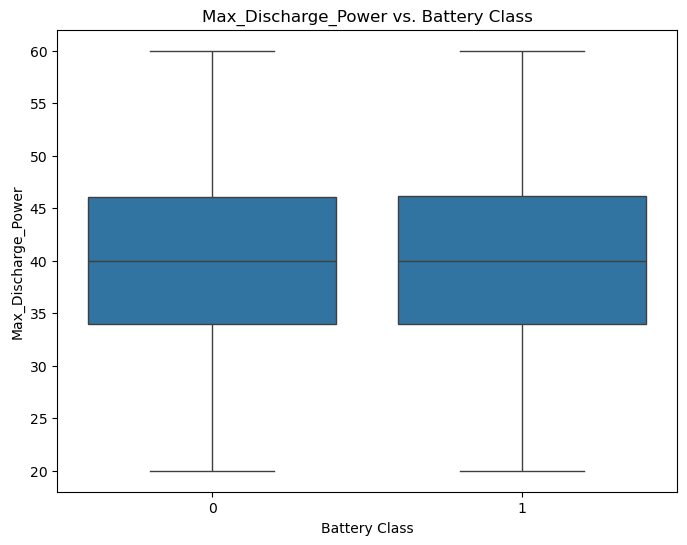

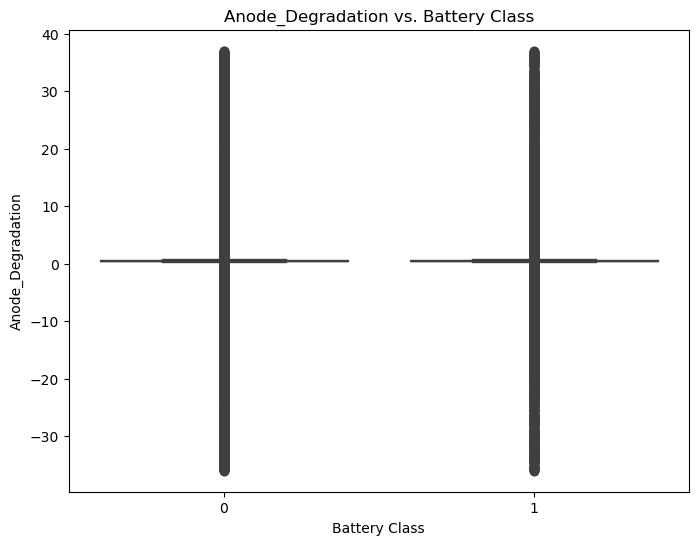

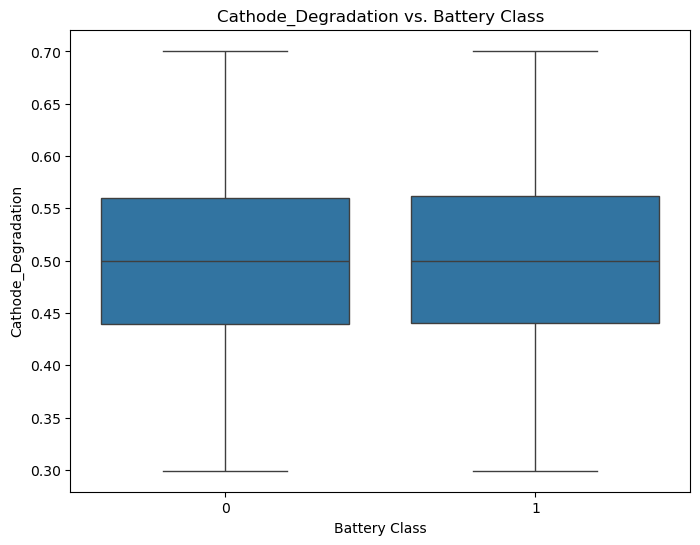

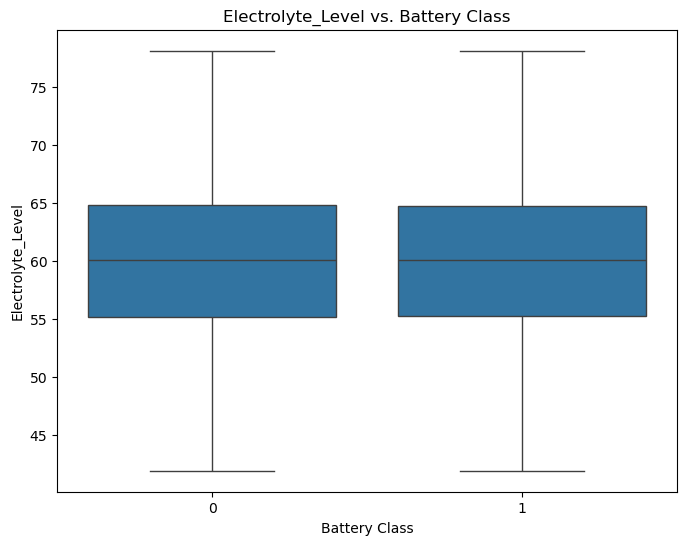

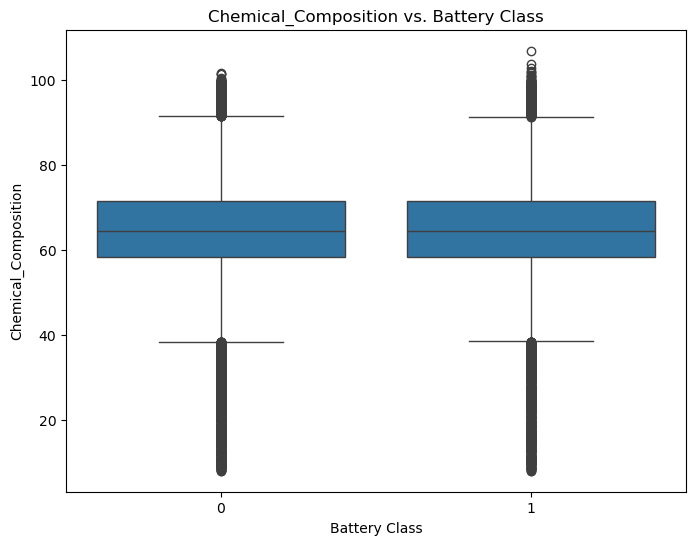

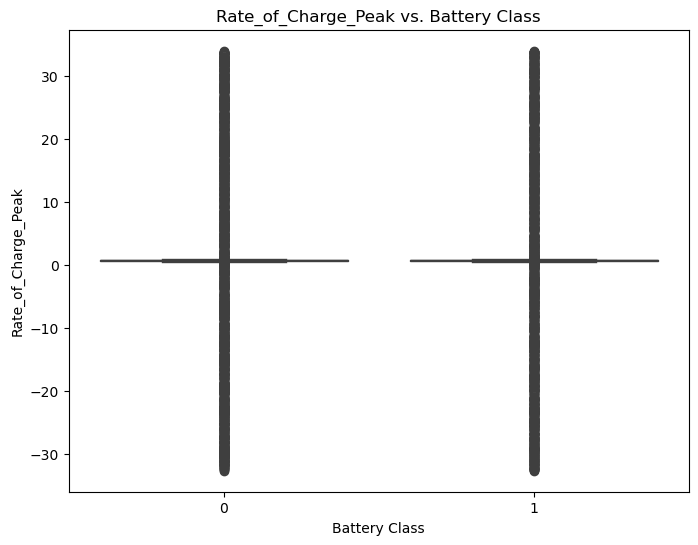

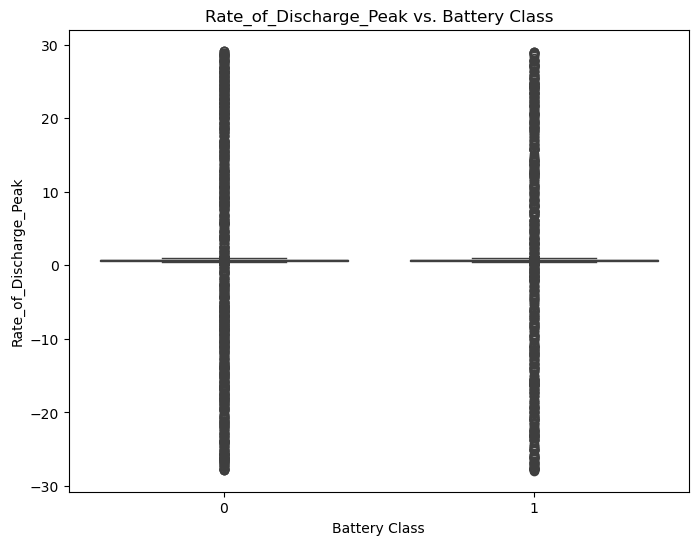

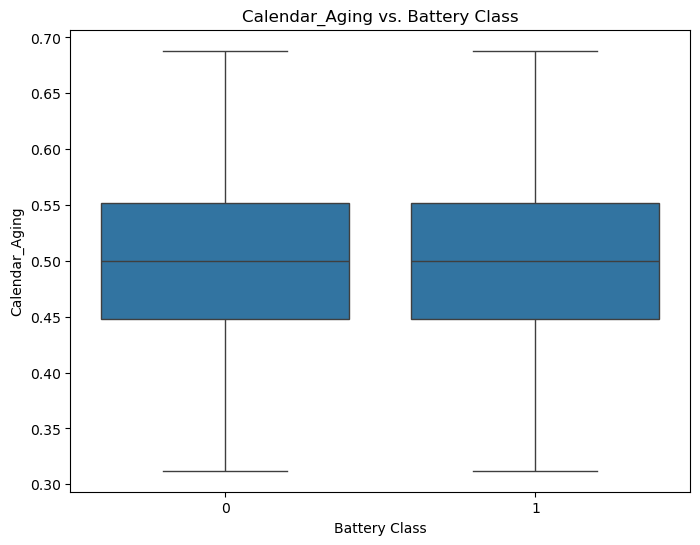

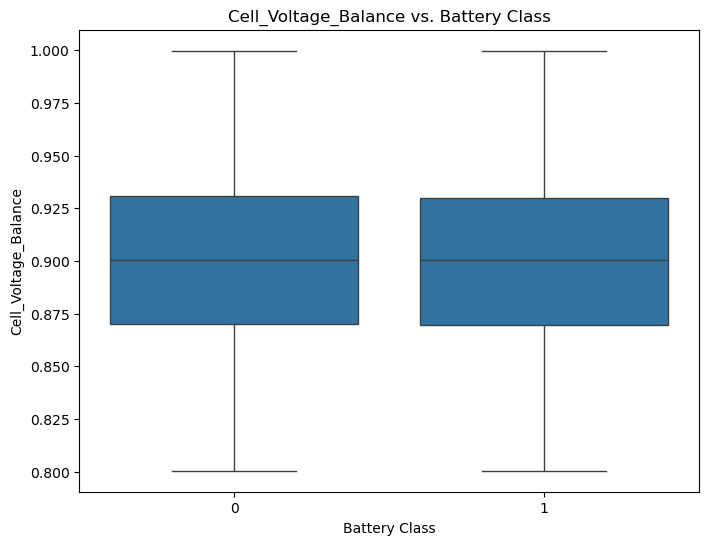

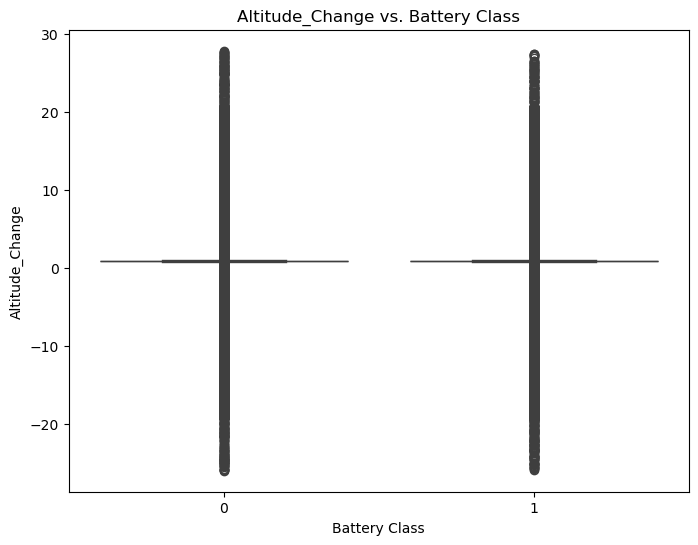

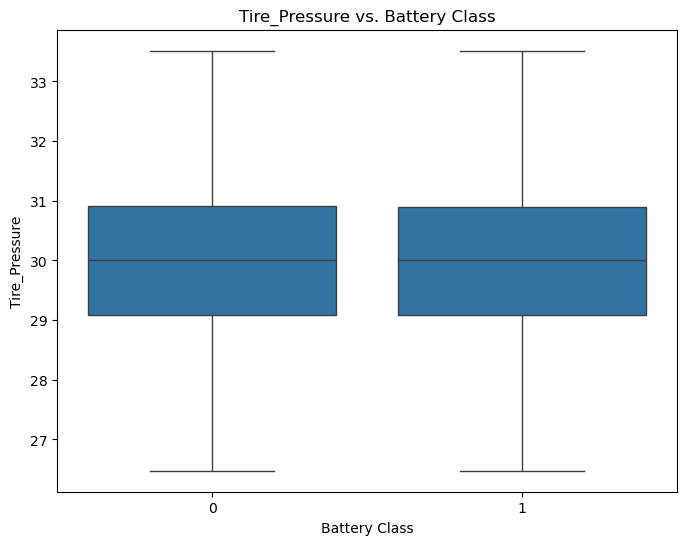

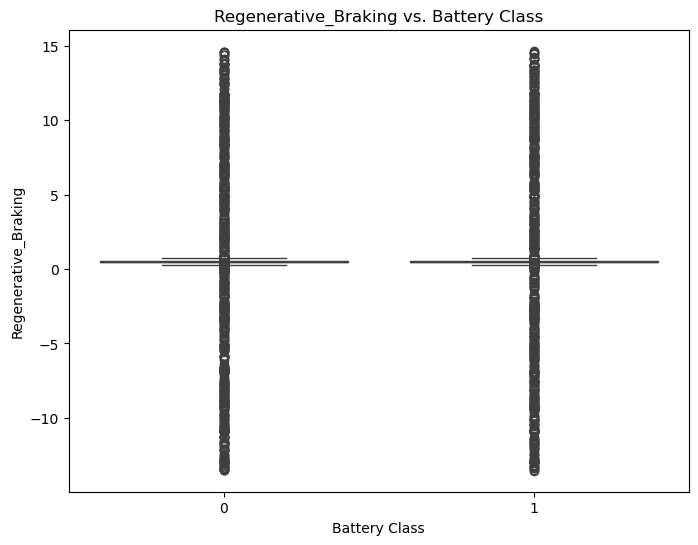

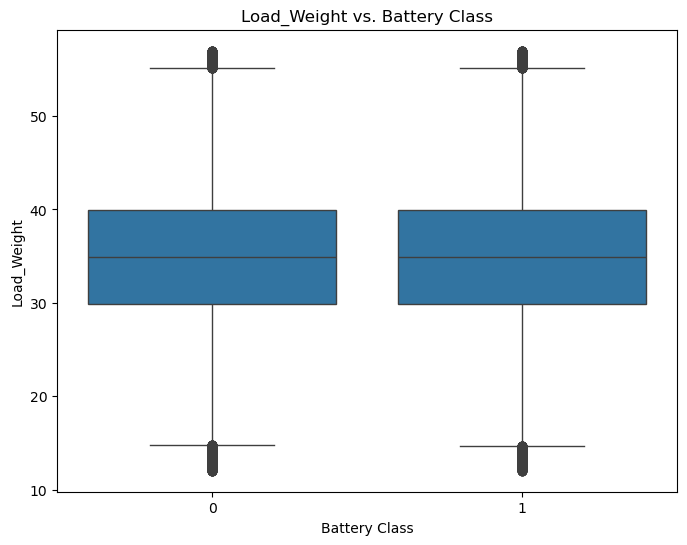

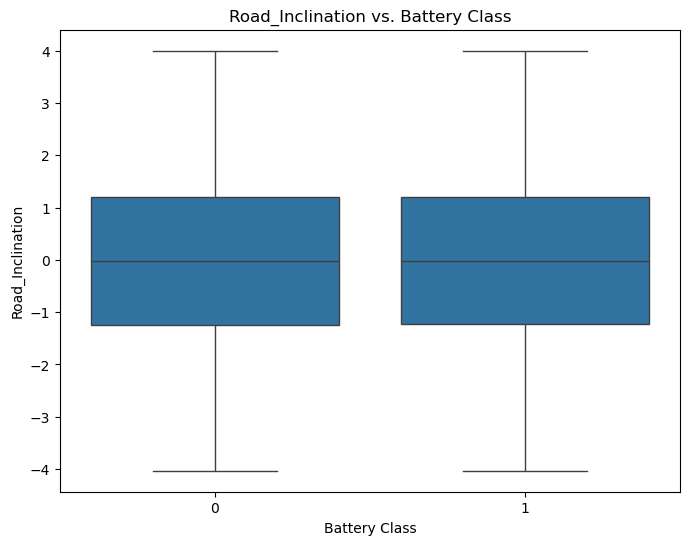

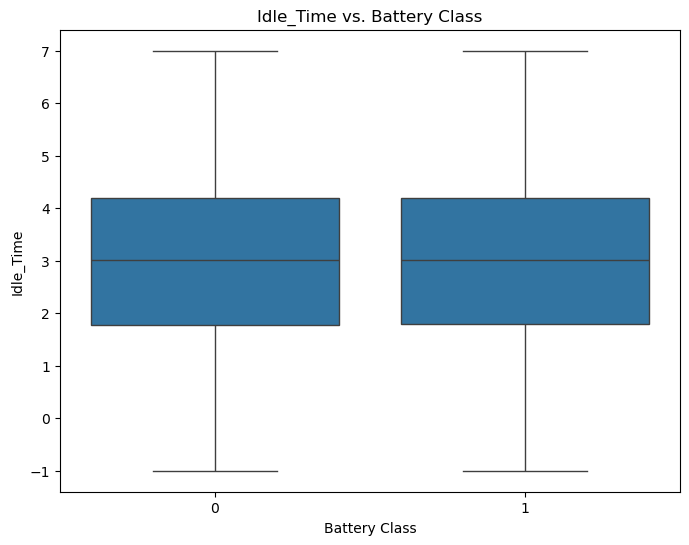

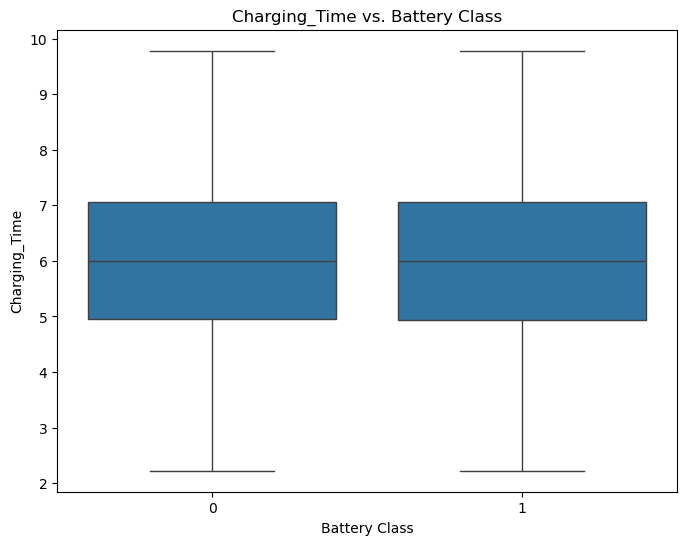

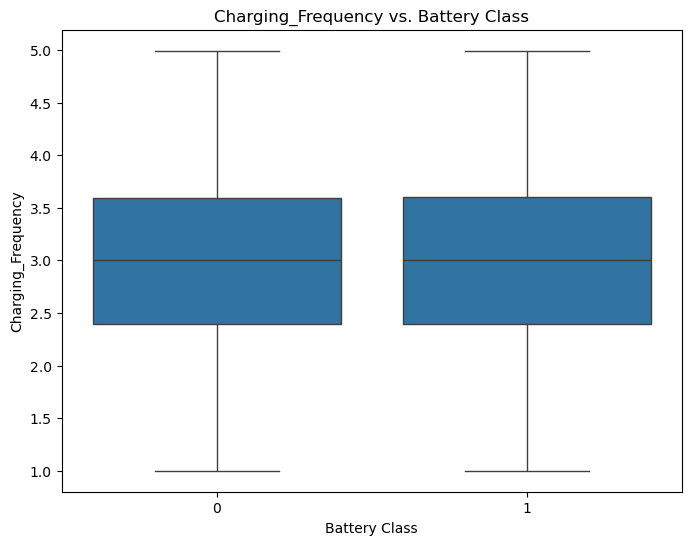

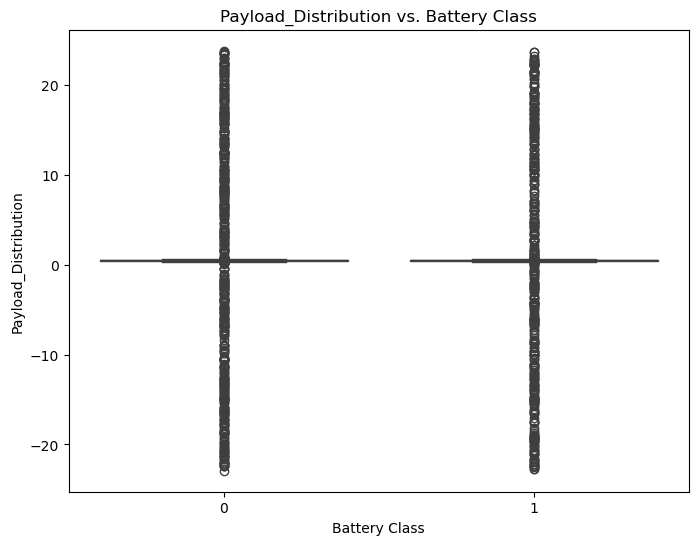

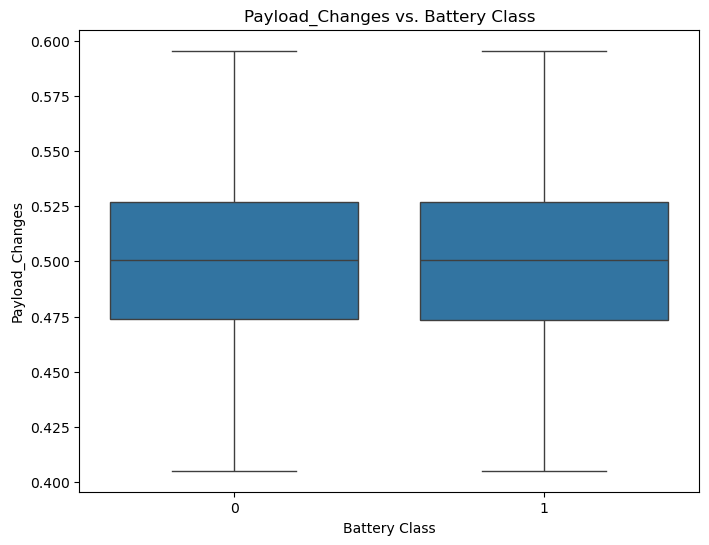

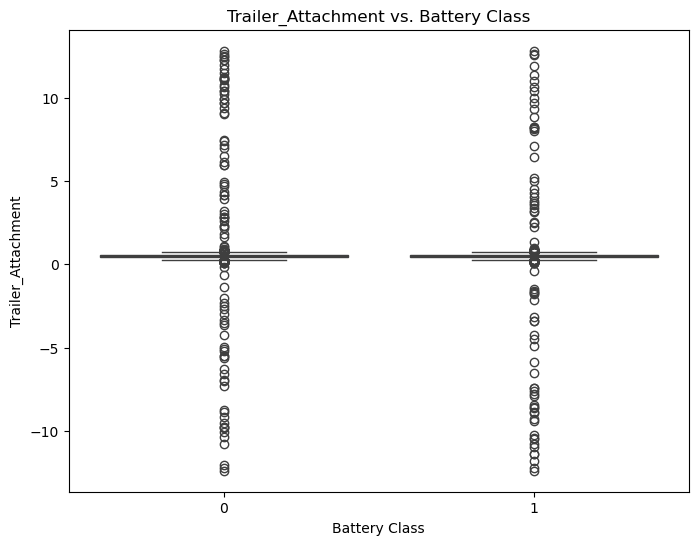

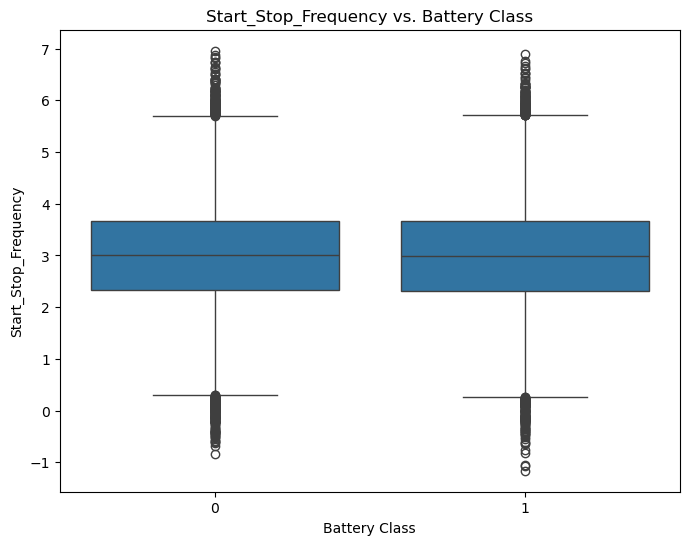

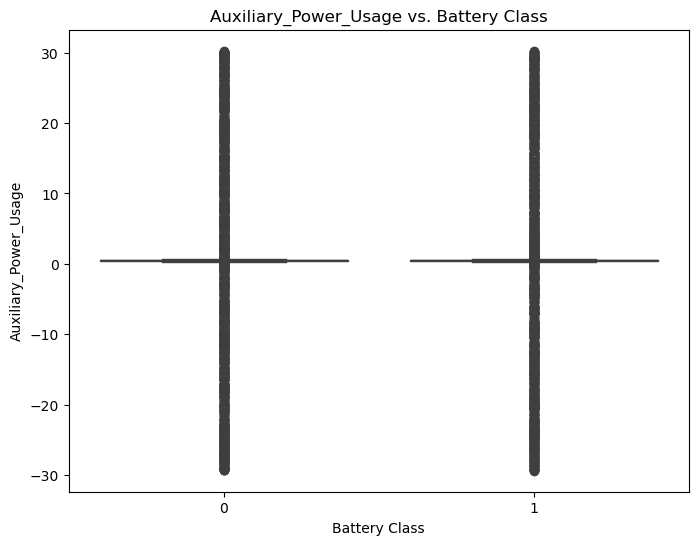

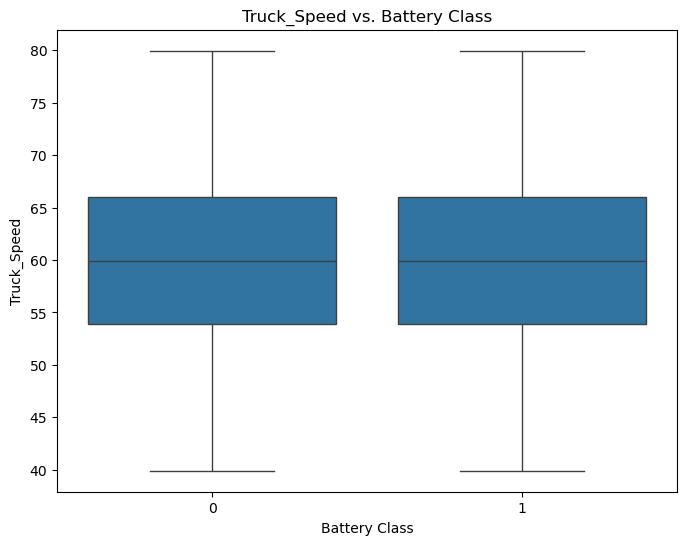

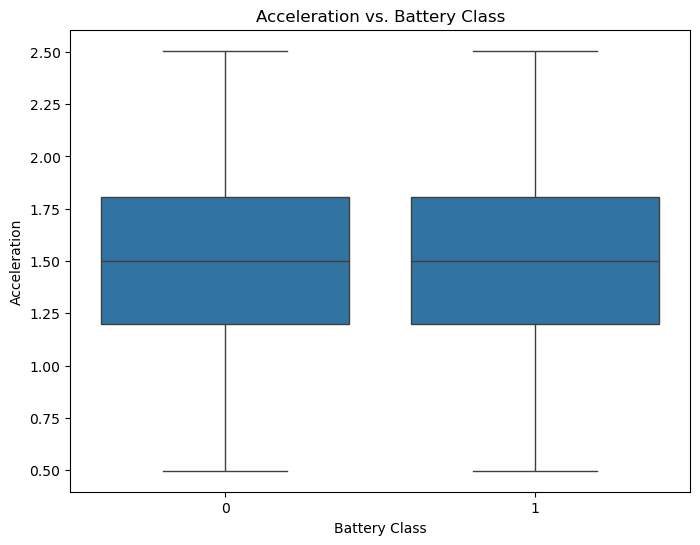

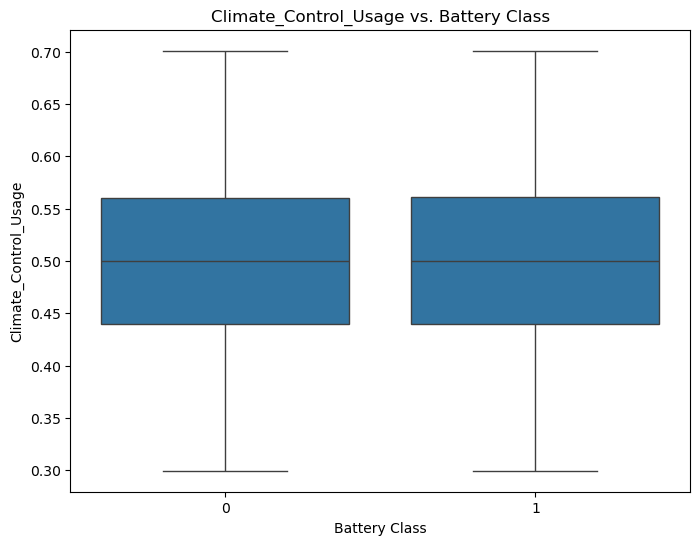

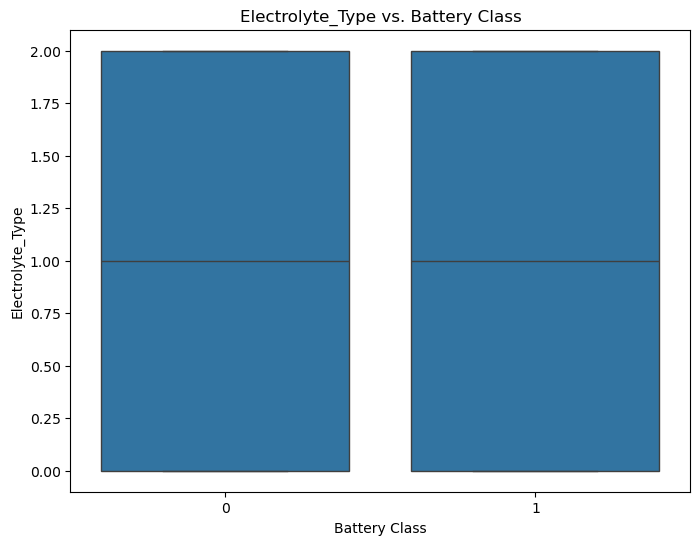

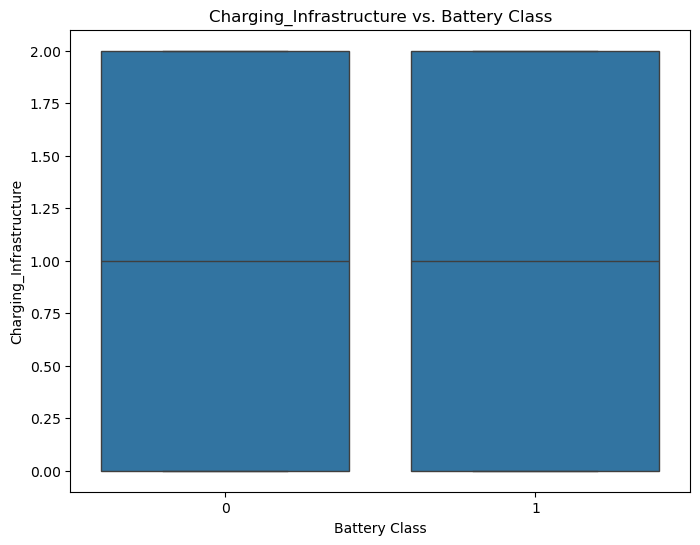

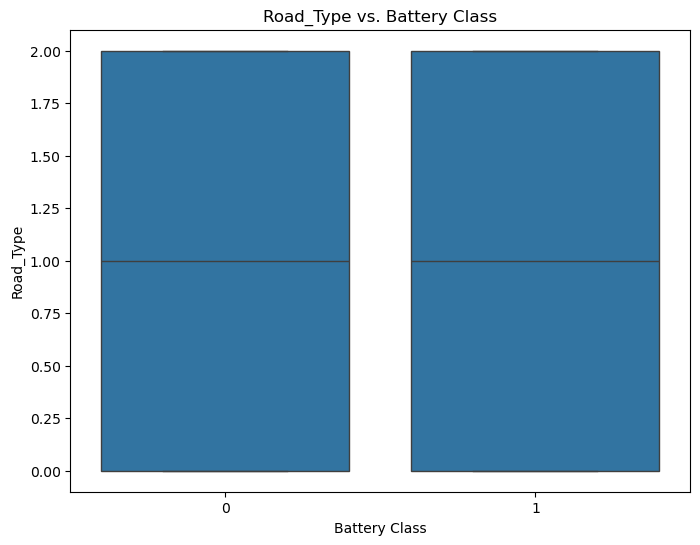

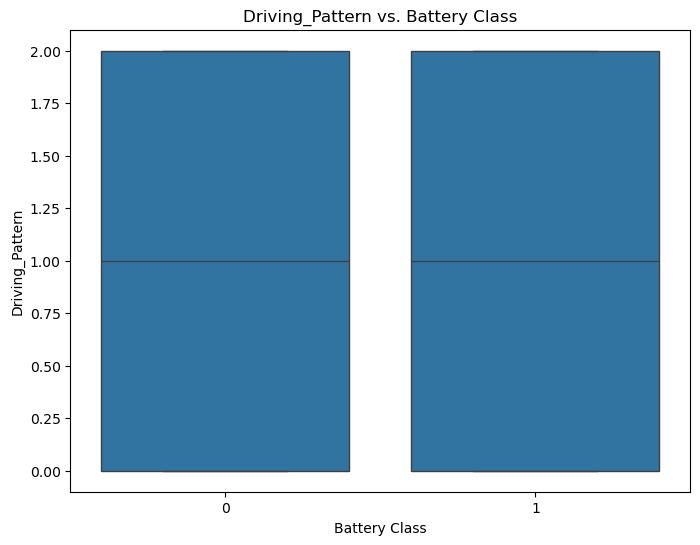

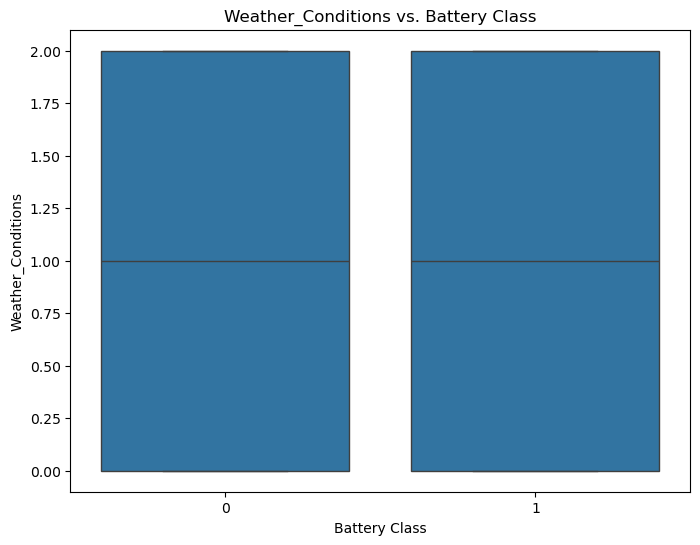

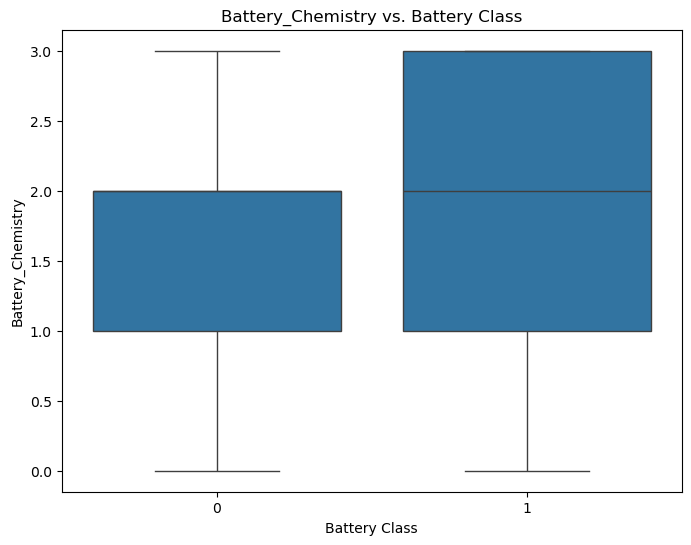

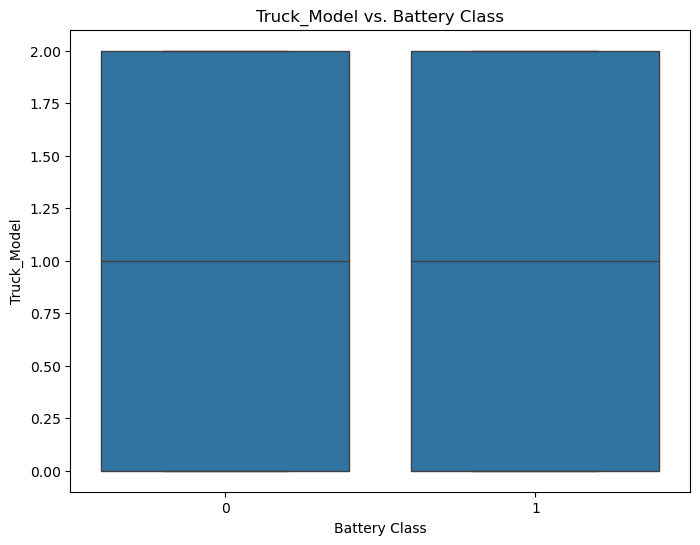

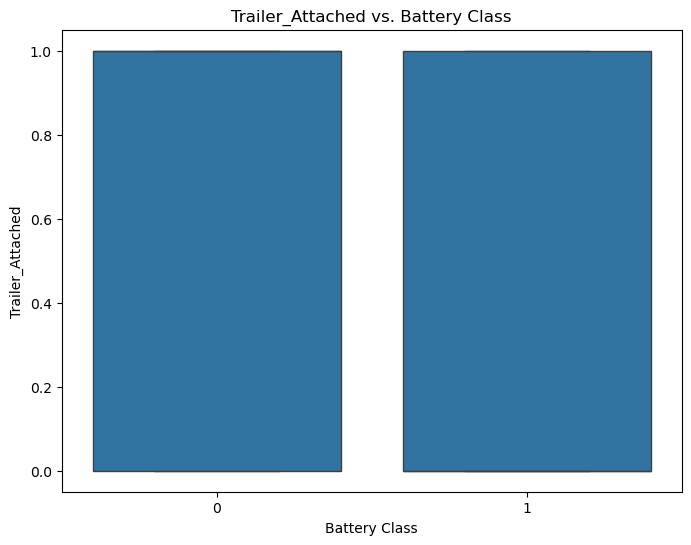

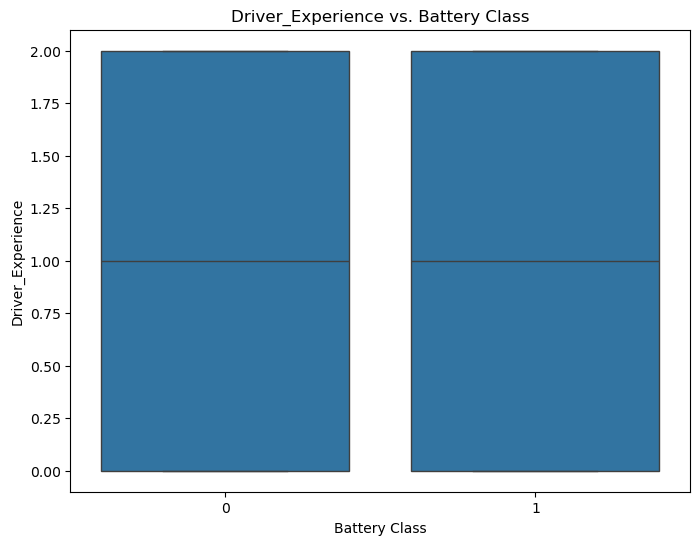

In [19]:
# Visualize relationships between numerical features and the target variable using box plots
print("\nBox plots of numerical features vs. Battery Class:")
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Battery_Class', y=col, data=processed_df)
    plt.title(f'{col} vs. Battery Class')
    plt.xlabel('Battery Class')
    plt.ylabel(col)
    plt.show()

In [20]:
# Check for missing values
print("\nMissing values in the dataframe:")
print(processed_df.isnull().sum())


Missing values in the dataframe:
State_of_Charge                    0
State_of_Health                    0
Voltage                            0
Current                            0
Temperature                        0
Cycling_Count                      0
Internal_Resistance                0
Rate_of_Charge                     0
Charge_Discharge_Efficiency        0
Depth_of_Discharge                 0
Charge_Rate                        0
Discharge_Rate                     0
Voltage_Sag                        0
Cell_Balancing_Status              0
Self_Discharge_Rate                0
EIS_Data                           0
Cycle_Life                         0
Max_Charge_Power                   0
Max_Discharge_Power                0
Anode_Degradation                  0
Cathode_Degradation                0
Electrolyte_Level                  0
Chemical_Composition               0
Rate_of_Charge_Peak                0
Rate_of_Discharge_Peak             0
Calendar_Aging                     0
Cell


Correlation heatmap of numerical features:


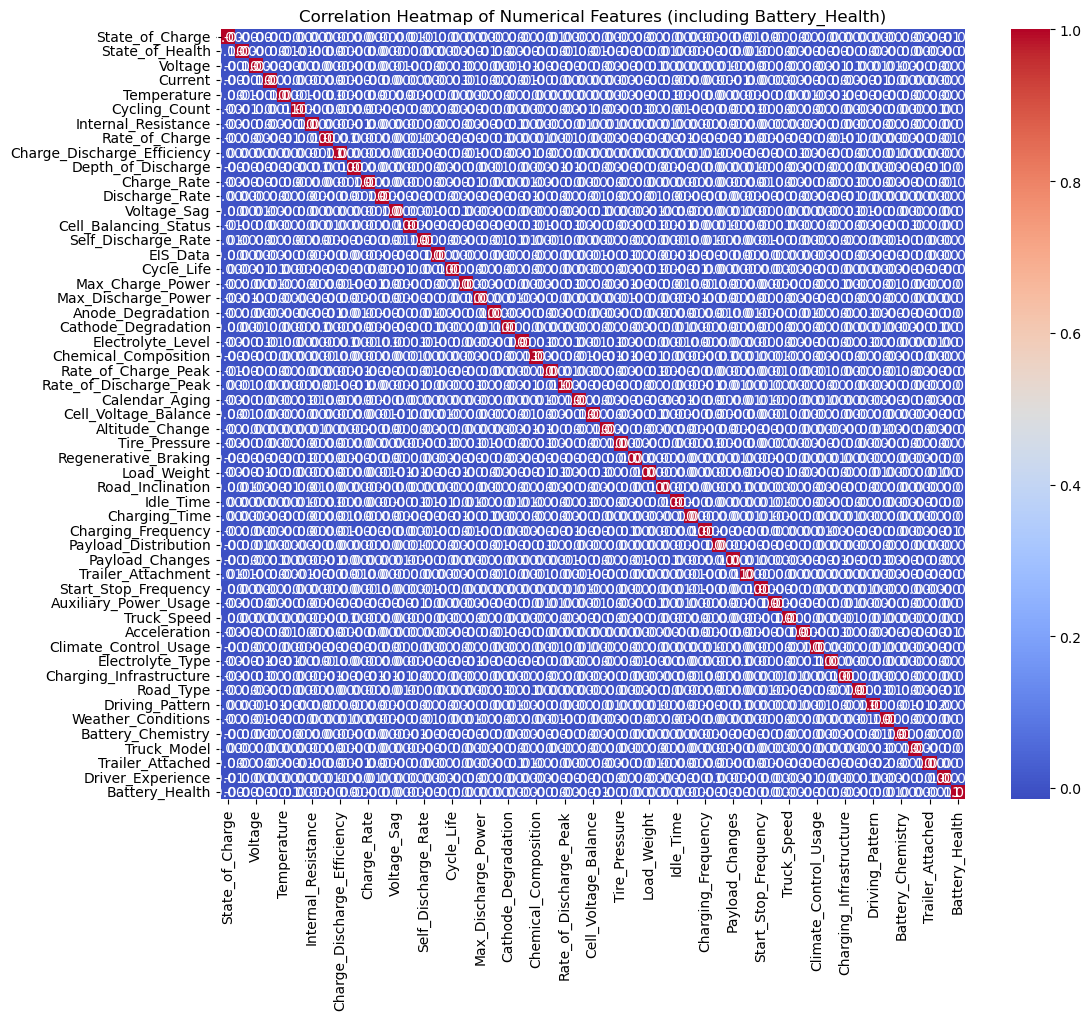

In [26]:
# Check for correlations between numerical features using a heatmap
print("\nCorrelation heatmap of numerical features:")
correlation_matrix = processed_df[numerical_cols + ['Battery_Health']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features (including Battery_Health)')
plt.show()

In [9]:
# 2. Define the target variable
target_variable = "Battery_Class"

# 3. Separate features (X) and target (y) - KEEPING 'Battery_Health'
if target_variable in processed_df.columns and 'Battery_Health' in processed_df.columns:
    y = processed_df[target_variable]
    X = processed_df.drop(target_variable, axis=1)
elif target_variable in processed_df.columns:
    print("Warning: 'Battery_Health' not found in the dataframe. Please ensure it's present.")
    exit()
else:
    print(f"Error: Target variable '{target_variable}' not found in the CSV file.")
    exit()

In [11]:
# --- Handle Missing Values using SimpleImputer ---
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# --- Check missing values AFTER imputation ---
print("\n--- Missing values AFTER imputation ---")
print(X_imputed.isnull().sum())


--- Missing values AFTER imputation ---
State_of_Charge                0
State_of_Health                0
Voltage                        0
Current                        0
Temperature                    0
Cycling_Count                  0
Internal_Resistance            0
Rate_of_Charge                 0
Charge_Discharge_Efficiency    0
Depth_of_Discharge             0
Charge_Rate                    0
Discharge_Rate                 0
Voltage_Sag                    0
Cell_Balancing_Status          0
Self_Discharge_Rate            0
EIS_Data                       0
Cycle_Life                     0
Max_Charge_Power               0
Max_Discharge_Power            0
Anode_Degradation              0
Cathode_Degradation            0
Electrolyte_Level              0
Chemical_Composition           0
Rate_of_Charge_Peak            0
Rate_of_Discharge_Peak         0
Calendar_Aging                 0
Cell_Voltage_Balance           0
Altitude_Change                0
Tire_Pressure                  0
Re

In [13]:
# 4. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [15]:
# --- Existing XGBoost Model ---
print("\n--- XGBoost Model ---")
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy on Test Set: {accuracy_xgb:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))


--- XGBoost Model ---


C:\Users\spakt\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:16:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on Test Set: 0.9981
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [42]:
# --- XGBoost Model with Moderate Regularization ---
print("\n--- XGBoost Model with Moderate Regularization ---")
model_xgb_reg = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    reg_alpha=0.5,          # Moderate L1 regularization
    reg_lambda=2,         # Moderate L2 regularization
    max_depth=3,          # Increased maximum depth
    min_child_weight=3,   # Increased minimum child weight
    subsample=0.7,        # Increased subsample ratio
    colsample_bytree=0.7, # Increased column subsample ratio
    learning_rate=0.05     # Increased learning rate
)
model_xgb_reg.fit(X_train, y_train)
y_pred_xgb_reg = model_xgb_reg.predict(X_test)
accuracy_xgb_reg = accuracy_score(y_test, y_pred_xgb_reg)
print(f"Accuracy on Test Set (Moderate Regularization): {accuracy_xgb_reg:.4f}")
print("Classification Report (Moderate Regularization):")
print(classification_report(y_test, y_pred_xgb_reg))

# --- Random Forest Model with Pruning and Depth Control ---
print("\n--- Random Forest Model with Pruning and Depth Control ---")
model_rf_reg = RandomForestClassifier(
    random_state=42,
    max_depth=8,          # Increased maximum depth
    min_samples_split=10, # Moderate minimum samples required to split
    min_samples_leaf=5,   # Moderate minimum samples in a leaf
    ccp_alpha=0.01        # Example complexity parameter for pruning
)
model_rf_reg.fit(X_train, y_train)
y_pred_rf_reg = model_rf_reg.predict(X_test)
accuracy_rf_reg = accuracy_score(y_test, y_pred_rf_reg)
print(f"Accuracy on Test Set (Pruning and Depth Control): {accuracy_rf_reg:.4f}")
print("Classification Report (Pruning and Depth Control):")
print(classification_report(y_test, y_pred_rf_reg))

# --- AdaBoost Model with Increased Estimators and Learning Rate ---
print("\n--- AdaBoost Model with Increased Complexity ---")
model_ada_reg = AdaBoostClassifier(
    random_state=42,
    n_estimators=80,      # Increased number of estimators
    learning_rate=0.2      # Increased learning rate
)
model_ada_reg.fit(X_train, y_train)
y_pred_ada_reg = model_ada_reg.predict(X_test)
accuracy_ada_reg = accuracy_score(y_test, y_pred_ada_reg)
print(f"Accuracy on Test Set (Increased Complexity): {accuracy_ada_reg:.4f}")
print("Classification Report (Increased Complexity):")
print(classification_report(y_test, y_pred_ada_reg))

# --- Gradient Boosting Model with Moderate Regularization ---
print("\n--- Gradient Boosting Model with Moderate Regularization ---")
model_gb_reg = GradientBoostingClassifier(
    random_state=42,
    max_depth=4,          # Increased maximum depth of trees
    min_samples_split=15, # Moderate minimum samples required to split
    min_samples_leaf=8,   # Moderate minimum samples in a leaf
    subsample=0.8,        # Increased subsample ratio
    learning_rate=0.05,     # Increased learning rate
    n_estimators=150       # Increased number of estimators
)
model_gb_reg.fit(X_train, y_train)
y_pred_gb_reg = model_gb_reg.predict(X_test)
accuracy_gb_reg = accuracy_score(y_test, y_pred_gb_reg)
print(f"Accuracy on Test Set (Moderate Regularization): {accuracy_gb_reg:.4f}")
print("Classification Report (Moderate Regularization):")
print(classification_report(y_test, y_pred_gb_reg))

# --- Bagging Model with Base RF and Moderate Parameters ---
print("\n--- Bagging Model with Moderate Parameters ---")
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier # Ensure BaggingClassifier is imported

base_rf_estimator = RandomForestClassifier(max_depth=10, min_samples_split=10, min_samples_leaf=5, ccp_alpha=0.01, random_state=42)

model_bag_reg = BaggingClassifier(
    estimator=base_rf_estimator,
    random_state=42,
    n_estimators=80,
    max_samples=0.8,
    max_features=0.8
)
model_bag_reg.fit(X_train, y_train)
y_pred_bag_reg = model_bag_reg.predict(X_test)
accuracy_bag_reg = accuracy_score(y_test, y_pred_bag_reg)
print(f"Accuracy on Test Set (Moderate Parameters): {accuracy_bag_reg:.4f}")
print("Classification Report (Moderate Parameters):")
print(classification_report(y_test, y_pred_bag_reg))

# --- Voting Classifier with Moderately Regularized Base Estimators ---
print("\n--- Voting Classifier with Moderate Regularization ---")
clf1_reg = LogisticRegression(random_state=42, C=0.1) # Moderate regularization for Logistic Regression (higher C)
clf2_reg = RandomForestClassifier(random_state=42, max_depth=8, min_samples_split=10, min_samples_leaf=5, ccp_alpha=0.01)
clf3_reg = GradientBoostingClassifier(random_state=42, max_depth=4, min_samples_split=15, min_samples_leaf=8, subsample=0.8, learning_rate=0.05, n_estimators=150)
eclf1_reg = VotingClassifier(estimators=[('lr', clf1_reg), ('rf', clf2_reg), ('gb', clf3_reg)], voting='hard')
eclf1_reg = eclf1_reg.fit(X_train, y_train)
y_pred_vc_reg = eclf1_reg.predict(X_test)
accuracy_vc_reg = accuracy_score(y_test, y_pred_vc_reg)
print(f"Accuracy on Test Set (Moderate Regularization): {accuracy_vc_reg:.4f}")
print("Classification Report (Moderate Regularization):")
print(classification_report(y_test, y_pred_vc_reg))

# --- Stacking Classifier with Moderately Regularized Base and Final Estimators ---
print("\n--- Stacking Classifier with Moderate Regularization ---")
estimators_reg = [
    ('rf', RandomForestClassifier(random_state=42, max_depth=8, min_samples_split=10, min_samples_leaf=5, ccp_alpha=0.01)),
    ('gb', GradientBoostingClassifier(random_state=42, max_depth=4, min_samples_split=15, min_samples_leaf=8, subsample=0.8, learning_rate=0.05, n_estimators=150))
]
clf_final_reg = LogisticRegression(random_state=42, C=0.1) # Moderate regularization for final estimator
sclf_reg = StackingClassifier(estimators=estimators_reg, final_estimator=clf_final_reg, cv=5)
sclf_reg.fit(X_train, y_train)
y_pred_st_reg = sclf_reg.predict(X_test)
accuracy_st_reg = accuracy_score(y_test, y_pred_st_reg)
print(f"Accuracy on Test Set (Moderate Regularization): {accuracy_st_reg:.4f}")
print("Classification Report (Moderate Regularization):")
print(classification_report(y_test, y_pred_st_reg))

# --- CatBoost Model with L2 Regularization ---
print("\n--- CatBoost Model with L2 Regularization ---")
model_cat = CatBoostClassifier(verbose=0, random_state=42, l2_leaf_reg=3) # Example of setting L2 regularization
model_cat.fit(X_train, y_train)
y_pred_cat = model_cat.predict(X_test)
accuracy_cat = accuracy_score(y_test, y_pred_cat)
print(f"Accuracy on Test Set (L2 Regularization): {accuracy_cat:.4f}")
print("Classification Report (L2 Regularization):")
print(classification_report(y_test, y_pred_cat))

# --- LogitBoost Model with Increased Complexity ---
print("\n--- LogitBoost Model with Increased Complexity ---")
model_logit_reg = AdaBoostClassifier(algorithm='SAMME', random_state=42, n_estimators=80, learning_rate=0.2) # Using the more regularized AdaBoost version
model_logit_reg.fit(X_train, y_train)
y_pred_logit_reg = model_logit_reg.predict(X_test)
accuracy_logit_reg = accuracy_score(y_test, y_pred_logit_reg)
print(f"Accuracy on Test Set (Increased Complexity): {accuracy_logit_reg:.4f}")
print("Classification Report (Increased Complexity):")
print(classification_report(y_test, y_pred_logit_reg))



--- XGBoost Model with Moderate Regularization ---


C:\Users\spakt\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on Test Set (Moderate Regularization): 0.9983
Classification Report (Moderate Regularization):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- Random Forest Model with Pruning and Depth Control ---
Accuracy on Test Set (Pruning and Depth Control): 0.9658
Classification Report (Pruning and Depth Control):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     11065
           1       1.00      0.92      0.96      8935

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.97     20000
weighted avg       0.97      0.97      0.97     20000


--- AdaBoost Model with Increased Complexity ---


C:\Users\spakt\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy on Test Set (Increased Complexity): 1.0000
Classification Report (Increased Complexity):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- Gradient Boosting Model with Moderate Regularization ---
Accuracy on Test Set (Moderate Regularization): 1.0000
Classification Report (Moderate Regularization):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- Bagging Model with Moderate Parameters ---
Accuracy on Test Set (Moderate Par

C:\Users\spakt\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on Test Set (Moderate Regularization): 0.9728
Classification Report (Moderate Regularization):
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     11065
           1       1.00      0.94      0.97      8935

    accuracy                           0.97     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000


--- Stacking Classifier with Moderate Regularization ---
Accuracy on Test Set (Moderate Regularization): 1.0000
Classification Report (Moderate Regularization):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- CatBoost Model with L2 Regularization ---
Accuracy on Test Set (L2 Regulari

In [35]:
# Now, split X_train and y_train into training and validation sets
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("\n--- XGBoost Model ---")
model_xgb_reg_tuned = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    reg_alpha=1,          # Increased L1 regularization
    reg_lambda=3,         # Increased L2 regularization
    max_depth=2,          # Reduced maximum depth
    min_child_weight=5,   # Increased minimum child weight
    subsample=0.6,        # Reduced subsample ratio
    colsample_bytree=0.6, # Reduced column subsample ratio
    learning_rate=0.01,   # Reduced learning rate
    n_estimators=200      # Increased estimators to compensate for lower learning rate
)

# Convert data to DMatrix format, which is used by the native XGBoost API
dtrain = xgb.DMatrix(X_train_new, label=y_train_new)
dval = xgb.DMatrix(X_val, label=y_val)

# Define parameters for training (you might want to adjust these)
params = model_xgb_reg_tuned.get_xgb_params()

# Train the model with early stopping
evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=model_xgb_reg_tuned.n_estimators,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=False  # Set to True to see evaluation during training
)

# Make predictions on the validation set
y_pred_proba_xgb_tuned = bst.predict(dval)
y_pred_xgb_tuned = (y_pred_proba_xgb_tuned > 0.5).astype(int) # Assuming binary classification

accuracy_xgb_reg_tuned = accuracy_score(y_val, y_pred_xgb_tuned)
print(f"Validation Accuracy (Tuned XGBoost): {accuracy_xgb_reg_tuned:.4f}")
print("Validation Classification Report (Tuned XGBoost):")
print(classification_report(y_val, y_pred_xgb_tuned))

# You can also get the number of boosting rounds used by the trained model
print(f"Number of boosting rounds used: {bst.best_iteration + 1}")

print("\n--- Random Forest Model ---")
model_rf_reg_tuned = RandomForestClassifier(
    random_state=42,
    max_depth=6,          # Reduced maximum depth
    min_samples_split=15, # Increased minimum samples required to split
    min_samples_leaf=8,   # Increased minimum samples in a leaf
    ccp_alpha=0.02        # Increased complexity parameter for pruning
)
model_rf_reg_tuned.fit(X_train_new, y_train_new)
y_pred_rf_reg_tuned = model_rf_reg_tuned.predict(X_val)
accuracy_rf_reg_tuned = accuracy_score(y_val, y_pred_rf_reg_tuned)
print(f"Validation Accuracy (Tuned Random Forest): {accuracy_rf_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Random Forest):")
print(classification_report(y_val, y_pred_rf_reg_tuned))

print("\n--- AdaBoost Model ---")
model_ada_reg_tuned = AdaBoostClassifier(
    random_state=42,
    n_estimators=50,      # Reduced number of estimators
    learning_rate=0.1      # Reduced learning rate
)
model_ada_reg_tuned.fit(X_train_new, y_train_new)
y_pred_ada_reg_tuned = model_ada_reg_tuned.predict(X_val)
accuracy_ada_reg_tuned = accuracy_score(y_val, y_pred_ada_reg_tuned)
print(f"Validation Accuracy (Tuned AdaBoost): {accuracy_ada_reg_tuned:.4f}")
print("Validation Classification Report (Tuned AdaBoost):")
print(classification_report(y_val, y_pred_ada_reg_tuned))

print("\n--- Gradient Boosting Model ---")
model_gb_reg_tuned = GradientBoostingClassifier(
    random_state=42,
    max_depth=3,          # Reduced maximum depth of trees
    min_samples_split=20, # Increased minimum samples required to split
    min_samples_leaf=10,  # Increased minimum samples in a leaf
    subsample=0.7,        # Reduced subsample ratio
    learning_rate=0.03,   # Reduced learning rate
    n_estimators=100      # Reduced number of estimators
)
model_gb_reg_tuned.fit(X_train_new, y_train_new)
y_pred_gb_reg_tuned = model_gb_reg_tuned.predict(X_val)
accuracy_gb_reg_tuned = accuracy_score(y_val, y_pred_gb_reg_tuned)
print(f"Validation Accuracy (Tuned Gradient Boosting): {accuracy_gb_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Gradient Boosting):")
print(classification_report(y_val, y_pred_gb_reg_tuned))

print("\n--- Bagging Model ---")
base_rf_estimator_tuned = RandomForestClassifier(max_depth=7, min_samples_split=12, min_samples_leaf=6, ccp_alpha=0.015, random_state=42)

model_bag_reg_tuned = BaggingClassifier(
    estimator=base_rf_estimator_tuned,
    random_state=42,
    n_estimators=60,      # Reduced number of estimators
    max_samples=0.7,      # Reduced max samples
    max_features=0.7      # Reduced max features
)
model_bag_reg_tuned.fit(X_train_new, y_train_new)
y_pred_bag_reg_tuned = model_bag_reg_tuned.predict(X_val)
accuracy_bag_reg_tuned = accuracy_score(y_val, y_pred_bag_reg_tuned)
print(f"Validation Accuracy (Tuned Bagging): {accuracy_bag_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Bagging):")
print(classification_report(y_val, y_pred_bag_reg_tuned))

print("\n--- Voting Classifier ---")
clf1_reg_tuned = LogisticRegression(random_state=42, C=0.05) # Increased regularization (lower C)
clf2_reg_tuned = RandomForestClassifier(random_state=42, max_depth=7, min_samples_split=12, min_samples_leaf=6, ccp_alpha=0.015)
clf3_reg_tuned = GradientBoostingClassifier(random_state=42, max_depth=3, min_samples_split=20, min_samples_leaf=10, subsample=0.7, learning_rate=0.03, n_estimators=100)
eclf1_reg_tuned = VotingClassifier(estimators=[('lr', clf1_reg_tuned), ('rf', clf2_reg_tuned), ('gb', clf3_reg_tuned)], voting='hard')
eclf1_reg_tuned = eclf1_reg_tuned.fit(X_train_new, y_train_new)
y_pred_vc_reg_tuned = eclf1_reg_tuned.predict(X_val)
accuracy_vc_reg_tuned = accuracy_score(y_val, y_pred_vc_reg_tuned)
print(f"Validation Accuracy (Tuned Voting Classifier): {accuracy_vc_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Voting Classifier):")
print(classification_report(y_val, y_pred_vc_reg_tuned))

print("\n--- Stacking Classifier ---")
estimators_reg_tuned = [
    ('rf', RandomForestClassifier(random_state=42, max_depth=7, min_samples_split=12, min_samples_leaf=6, ccp_alpha=0.015)),
    ('gb', GradientBoostingClassifier(random_state=42, max_depth=3, min_samples_split=20, min_samples_leaf=10, subsample=0.7, learning_rate=0.03, n_estimators=100))
]
clf_final_reg_tuned = LogisticRegression(random_state=42, C=0.05) # Increased regularization (lower C)
sclf_reg_tuned = StackingClassifier(estimators=estimators_reg_tuned, final_estimator=clf_final_reg_tuned, cv=5)
sclf_reg_tuned.fit(X_train_new, y_train_new)
y_pred_st_reg_tuned = sclf_reg_tuned.predict(X_val)
accuracy_st_reg_tuned = accuracy_score(y_val, y_pred_st_reg_tuned)
print(f"Validation Accuracy (Tuned Stacking Classifier): {accuracy_st_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Stacking Classifier):")
print(classification_report(y_val, y_pred_st_reg_tuned))

print("\n--- CatBoost Model ---")
model_cat_tuned = CatBoostClassifier(verbose=0, random_state=42, l2_leaf_reg=5, depth=6) # Increased L2, reduced depth
model_cat_tuned.fit(X_train_new, y_train_new, eval_set=[(X_val, y_val)], early_stopping_rounds=10)
y_pred_cat_tuned = model_cat_tuned.predict(X_val)
accuracy_cat_tuned = accuracy_score(y_val, y_pred_cat_tuned)
print(f"Validation Accuracy (Tuned CatBoost): {accuracy_cat_tuned:.4f}")
print("Validation Classification Report (Tuned CatBoost):")
print(classification_report(y_val, y_pred_cat_tuned))

print("\n--- LogitBoost Model ---")
model_logit_reg_tuned = AdaBoostClassifier(algorithm='SAMME', random_state=42, n_estimators=50, learning_rate=0.1) # Reduced estimators and learning rate
model_logit_reg_tuned.fit(X_train_new, y_train_new)
y_pred_logit_reg_tuned = model_logit_reg_tuned.predict(X_val)
accuracy_logit_reg_tuned = accuracy_score(y_val, y_pred_logit_reg_tuned)
print(f"Validation Accuracy (Tuned LogitBoost): {accuracy_logit_reg_tuned:.4f}")
print("Validation Classification Report (Tuned LogitBoost):")
print(classification_report(y_val, y_pred_logit_reg_tuned))


--- XGBoost Model ---


C:\Users\spakt\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy (Tuned XGBoost): 0.9619
Validation Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8927
           1       1.00      0.91      0.95      7073

    accuracy                           0.96     16000
   macro avg       0.97      0.96      0.96     16000
weighted avg       0.96      0.96      0.96     16000

Number of boosting rounds used: 199

--- Random Forest Model ---
Validation Accuracy (Tuned Random Forest): 0.9650
Validation Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8927
           1       1.00      0.92      0.96      7073

    accuracy                           0.96     16000
   macro avg       0.97      0.96      0.96     16000
weighted avg       0.97      0.96      0.96     16000


--- AdaBoost Model ---


C:\Users\spakt\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation Accuracy (Tuned AdaBoost): 1.0000
Validation Classification Report (Tuned AdaBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8927
           1       1.00      1.00      1.00      7073

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000


--- Gradient Boosting Model ---
Validation Accuracy (Tuned Gradient Boosting): 1.0000
Validation Classification Report (Tuned Gradient Boosting):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8927
           1       1.00      1.00      1.00      7073

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000


--- Bagging Model ---
Validation Accuracy (Tuned Bagging): 0.9650
Validation Classification Report (Tu

C:\Users\spakt\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy (Tuned Voting Classifier): 0.9713
Validation Classification Report (Tuned Voting Classifier):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8927
           1       1.00      0.94      0.97      7073

    accuracy                           0.97     16000
   macro avg       0.98      0.97      0.97     16000
weighted avg       0.97      0.97      0.97     16000


--- Stacking Classifier ---
Validation Accuracy (Tuned Stacking Classifier): 1.0000
Validation Classification Report (Tuned Stacking Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8927
           1       1.00      1.00      1.00      7073

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000


--- CatBoost Model ---
Validation Accuracy (Tuned CatBoost): 0.9999
Validation Class

In [63]:
# Now, split X_train and y_train into training and validation sets
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("\n--- XGBoost Model ---")
model_xgb_reg_tuned = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    reg_alpha=1,
    reg_lambda=3,
    max_depth=2,
    min_child_weight=5,
    subsample=0.6,
    colsample_bytree=0.6,
    learning_rate=0.01,
    n_estimators=200
)

# Convert data to DMatrix format, which is used by the native XGBoost API
dtrain = xgb.DMatrix(X_train_new, label=y_train_new)
dval = xgb.DMatrix(X_val, label=y_val)

# Define parameters for training (you might want to adjust these)
params = model_xgb_reg_tuned.get_xgb_params()

# Train the model with early stopping
evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=model_xgb_reg_tuned.n_estimators,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=False  # Set to True to see evaluation during training
)

# Make predictions on the validation set
y_pred_proba_xgb_tuned = bst.predict(dval)
y_pred_xgb_tuned = (y_pred_proba_xgb_tuned > 0.5).astype(int) # Assuming binary classification

accuracy_xgb_reg_tuned = accuracy_score(y_val, y_pred_xgb_tuned)
print(f"Validation Accuracy (Tuned XGBoost): {accuracy_xgb_reg_tuned:.4f}")
print("Validation Classification Report (Tuned XGBoost):")
print(classification_report(y_val, y_pred_xgb_tuned))

# You can also get the number of boosting rounds used by the trained model
print(f"Number of boosting rounds used: {bst.best_iteration + 1}")

print("\n--- Random Forest Model ---")
model_rf_reg_tuned = RandomForestClassifier(
    random_state=42,
    max_depth=6,
    min_samples_split=15,
    min_samples_leaf=8,
    ccp_alpha=0.02
)
model_rf_reg_tuned.fit(X_train_new, y_train_new)
y_pred_rf_reg_tuned = model_rf_reg_tuned.predict(X_val)
accuracy_rf_reg_tuned = accuracy_score(y_val, y_pred_rf_reg_tuned)
print(f"Validation Accuracy (Tuned Random Forest): {accuracy_rf_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Random Forest):")
print(classification_report(y_val, y_pred_rf_reg_tuned))

print("\n--- AdaBoost Model ---")
model_ada_reg_tuned = AdaBoostClassifier(
    random_state=42,
    n_estimators=30,  # Further reduced number of estimators
    learning_rate=0.05  # Further reduced learning rate
)
model_ada_reg_tuned.fit(X_train_new, y_train_new)
y_pred_ada_reg_tuned = model_ada_reg_tuned.predict(X_val)
accuracy_ada_reg_tuned = accuracy_score(y_val, y_pred_ada_reg_tuned)
print(f"Validation Accuracy (Tuned AdaBoost): {accuracy_ada_reg_tuned:.4f}")
print("Validation Classification Report (Tuned AdaBoost):")
print(classification_report(y_val, y_pred_ada_reg_tuned))

print("\n--- Gradient Boosting Model ---")
model_gb_reg_tuned = GradientBoostingClassifier(
    random_state=42,
    max_depth=3,
    min_samples_split=30, # Increased minimum samples required to split
    min_samples_leaf=15, # Increased minimum samples in a leaf
    subsample=0.6,       # Further reduced subsample ratio
    learning_rate=0.02,  # Further reduced learning rate
    n_estimators=80      # Further reduced number of estimators
)
model_gb_reg_tuned.fit(X_train_new, y_train_new)
y_pred_gb_reg_tuned = model_gb_reg_tuned.predict(X_val)
accuracy_gb_reg_tuned = accuracy_score(y_val, y_pred_gb_reg_tuned)
print(f"Validation Accuracy (Tuned Gradient Boosting): {accuracy_gb_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Gradient Boosting):")
print(classification_report(y_val, y_pred_gb_reg_tuned))

print("\n--- Bagging Model ---")
base_rf_estimator_tuned = RandomForestClassifier(max_depth=7, min_samples_split=12, min_samples_leaf=6, ccp_alpha=0.015, random_state=42)

model_bag_reg_tuned = BaggingClassifier(
    estimator=base_rf_estimator_tuned,
    random_state=42,
    n_estimators=50,    
    max_samples=0.6,   
    max_features=0.6    
)
model_bag_reg_tuned.fit(X_train_new, y_train_new)
y_pred_bag_reg_tuned = model_bag_reg_tuned.predict(X_val)
accuracy_bag_reg_tuned = accuracy_score(y_val, y_pred_bag_reg_tuned)
print(f"Validation Accuracy (Tuned Bagging): {accuracy_bag_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Bagging):")
print(classification_report(y_val, y_pred_bag_reg_tuned))

print("\n--- Voting Classifier ---")
clf1_reg_tuned = LogisticRegression(random_state=42, C=0.05) 
clf2_reg_tuned = RandomForestClassifier(random_state=42, max_depth=7, min_samples_split=12, min_samples_leaf=6, ccp_alpha=0.015)
clf3_reg_tuned = GradientBoostingClassifier(random_state=42, max_depth=3, min_samples_split=20, min_samples_leaf=10, subsample=0.7, learning_rate=0.03, n_estimators=100)
eclf1_reg_tuned = VotingClassifier(estimators=[('lr', clf1_reg_tuned), ('rf', clf2_reg_tuned), ('gb', clf3_reg_tuned)], voting='hard')
eclf1_reg_tuned = eclf1_reg_tuned.fit(X_train_new, y_train_new)
y_pred_vc_reg_tuned = eclf1_reg_tuned.predict(X_val)
accuracy_vc_reg_tuned = accuracy_score(y_val, y_pred_vc_reg_tuned)
print(f"Validation Accuracy (Tuned Voting Classifier): {accuracy_vc_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Voting Classifier):")
print(classification_report(y_val, y_pred_vc_reg_tuned))

print("\n--- Stacking Classifier ---")
estimators_reg_tuned = [
    ('rf', RandomForestClassifier(random_state=42, max_depth=7, min_samples_split=12, min_samples_leaf=6, ccp_alpha=0.015)),
    ('gb', GradientBoostingClassifier(random_state=42, max_depth=3, min_samples_split=20, min_samples_leaf=10, subsample=0.7, learning_rate=0.03, n_estimators=100))
]
clf_final_reg_tuned = LogisticRegression(random_state=42, C=0.01) # Further increased regularization (lower C)
sclf_reg_tuned = StackingClassifier(estimators=estimators_reg_tuned, final_estimator=clf_final_reg_tuned, cv=5)
sclf_reg_tuned.fit(x)
y_pred_st_reg_tuned = sclf_reg_tuned.predict(X_val)
accuracy_st_reg_tuned = accuracy_score(y_val, y_pred_st_reg_tuned)
print(f"Validation Accuracy (Tuned Stacking Classifier): {accuracy_st_reg_tuned:.4f}")
print("Validation Classification Report (Tuned Stacking Classifier):")
print(classification_report(y_val, y_pred_st_reg_tuned))

print("\n--- CatBoost Model ---")
model_cat_tuned = CatBoostClassifier(verbose=0, random_state=42, l2_leaf_reg=5, depth=6) # Increased L2, reduced depth was already done


--- XGBoost Model ---


C:\Users\spakt\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy (Tuned XGBoost): 0.9619
Validation Classification Report (Tuned XGBoost):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8927
           1       1.00      0.91      0.95      7073

    accuracy                           0.96     16000
   macro avg       0.97      0.96      0.96     16000
weighted avg       0.96      0.96      0.96     16000

Number of boosting rounds used: 199

--- Random Forest Model ---
Validation Accuracy (Tuned Random Forest): 0.9650
Validation Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8927
           1       1.00      0.92      0.96      7073

    accuracy                           0.96     16000
   macro avg       0.97      0.96      0.96     16000
weighted avg       0.97      0.96      0.96     16000


--- AdaBoost Model ---


C:\Users\spakt\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation Accuracy (Tuned AdaBoost): 0.9650
Validation Classification Report (Tuned AdaBoost):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8927
           1       1.00      0.92      0.96      7073

    accuracy                           0.96     16000
   macro avg       0.97      0.96      0.96     16000
weighted avg       0.97      0.96      0.96     16000


--- Gradient Boosting Model ---
Validation Accuracy (Tuned Gradient Boosting): 1.0000
Validation Classification Report (Tuned Gradient Boosting):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8927
           1       1.00      1.00      1.00      7073

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000


--- Bagging Model ---
Validation Accuracy (Tuned Bagging): 0.9650
Validation Classification Report (Tu

C:\Users\spakt\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy (Tuned Voting Classifier): 0.9713
Validation Classification Report (Tuned Voting Classifier):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8927
           1       1.00      0.94      0.97      7073

    accuracy                           0.97     16000
   macro avg       0.98      0.97      0.97     16000
weighted avg       0.97      0.97      0.97     16000


--- Stacking Classifier ---
Validation Accuracy (Tuned Stacking Classifier): 1.0000
Validation Classification Report (Tuned Stacking Classifier):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8927
           1       1.00      1.00      1.00      7073

    accuracy                           1.00     16000
   macro avg       1.00      1.00      1.00     16000
weighted avg       1.00      1.00      1.00     16000


--- CatBoost Model ---


In [91]:
print("\n--- Extra Trees Model ---")
from sklearn.ensemble import ExtraTreesClassifier # Ensure ExtraTreesClassifier is imported if not already
model_et_tuned = ExtraTreesClassifier(random_state=42) # Using default parameters for simplicity
model_et_tuned.fit(X_train_new, y_train_new)
y_pred_et_tuned = model_et_tuned.predict(X_val)
accuracy_et_tuned = accuracy_score(y_val, y_pred_et_tuned)
print(f"Validation Accuracy (Tuned Extra Trees): {accuracy_et_tuned:.4f}")
print("Validation Classification Report (Tuned Extra Trees):")
print(classification_report(y_val, y_pred_et_tuned))


--- Extra Trees Model ---
Validation Accuracy (Tuned Extra Trees): 0.9292
Validation Classification Report (Tuned Extra Trees):
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      8927
           1       1.00      0.84      0.91      7073

    accuracy                           0.93     16000
   macro avg       0.94      0.92      0.93     16000
weighted avg       0.94      0.93      0.93     16000



In [125]:
print("\n--- LogitBoost Model ---")
model_logit_reg_tuned = AdaBoostClassifier(algorithm='SAMME', random_state=42, n_estimators=50, learning_rate=0.1) # These were already reduced
model_logit_reg_tuned.fit(X_train_new, y_train_new)
y_pred_logit_reg_tuned = model_logit_reg_tuned.predict(X_val)
accuracy_logit_reg_tuned = accuracy_score(y_val, y_pred_logit_reg_tuned)
print(f"Validation Accuracy (Tuned LogitBoost): {accuracy_logit_reg_tuned:.4f}")
print("Validation Classification Report (Tuned LogitBoost):")
print(classification_report(y_val, y_pred_logit_reg_tuned))


--- LogitBoost Model ---
Validation Accuracy (Tuned LogitBoost): 0.9650
Validation Classification Report (Tuned LogitBoost):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8927
           1       1.00      0.92      0.96      7073

    accuracy                           0.96     16000
   macro avg       0.97      0.96      0.96     16000
weighted avg       0.97      0.96      0.96     16000



In [123]:

print("\n--- CatBoost Model ---")
model_cat_tuned = CatBoostClassifier(
    verbose=0,
    random_state=42,
    l2_leaf_reg=20,      # Further Increased L2 regularization
    depth=3,             # Further Reduced tree depth
    learning_rate=0.005, # Further Reduced learning rate
    iterations=25,       # Significantly Reduced number of boosting iterations
    colsample_bylevel=0.7 # Correct parameter for feature subsampling in CatBoost
)
model_cat_tuned.fit(X_train_new, y_train_new, eval_set=[(X_val, y_val)], early_stopping_rounds=10)
y_pred_cat_tuned = model_cat_tuned.predict(X_val)
accuracy_cat_tuned = accuracy_score(y_val, y_pred_cat_tuned)
print(f"Validation Accuracy: {accuracy_cat_tuned:.4f}")
print("Validation Classification Report :")
print(classification_report(y_val, y_pred_cat_tuned))



--- CatBoost Model ---
Validation Accuracy: 0.9650
Validation Classification Report :
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8927
           1       1.00      0.92      0.96      7073

    accuracy                           0.96     16000
   macro avg       0.97      0.96      0.96     16000
weighted avg       0.97      0.96      0.96     16000



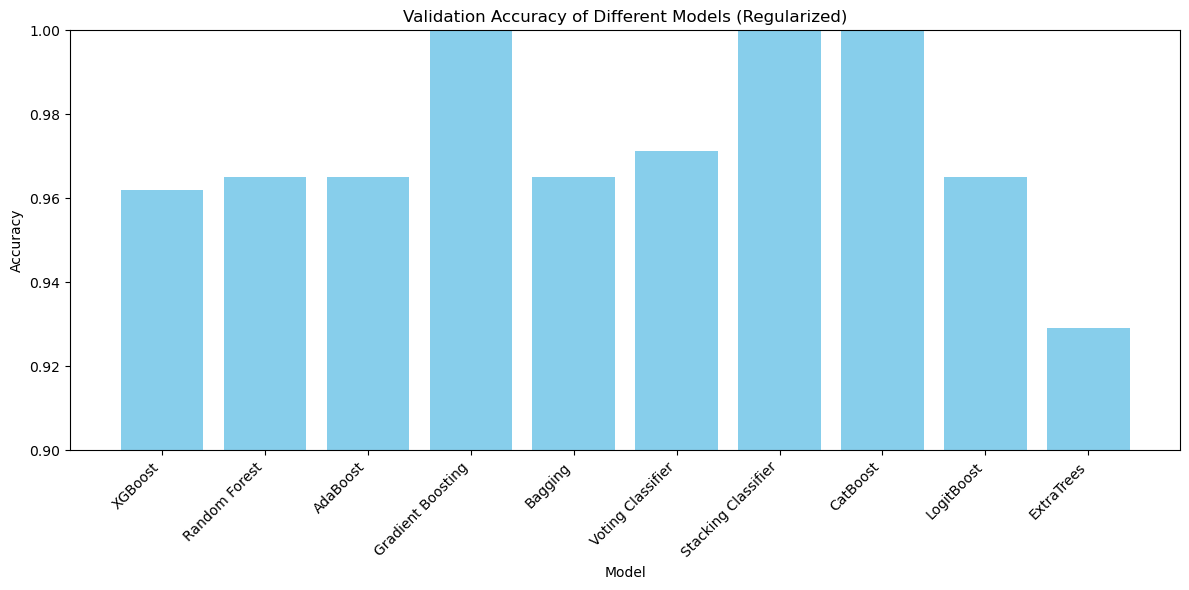

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# --- Accuracy Scores ---
model_names = [
    "XGBoost",
    "Random Forest",
    "AdaBoost",
    "Gradient Boosting",
    "Bagging",
    "Voting Classifier",
    "Stacking Classifier",
    "CatBoost",
    "LogitBoost",
    "ExtraTrees"
]

# After running the code above, replace these with the actual validation accuracy scores
accuracy_scores = np.array([
    accuracy_xgb_reg_tuned,
    accuracy_rf_reg_tuned,
    accuracy_ada_reg_tuned,
    accuracy_gb_reg_tuned,
    accuracy_bag_reg_tuned,
    accuracy_vc_reg_tuned,
    accuracy_st_reg_tuned,
    accuracy_cat_tuned,
    accuracy_logit_reg_tuned,
    accuracy_et_tuned
])

# --- Create the Bar Chart ---
plt.figure(figsize=(12, 6))
plt.bar(model_names, accuracy_scores, color='skyblue')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy of Different Models (Regularized)")
plt.ylim(0.9, 1.0) # Set y-axis limits for better visualization
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- SHAP Analysis (for XGBoost as an example) ---
The shape of shap_values is: (20000, 53)


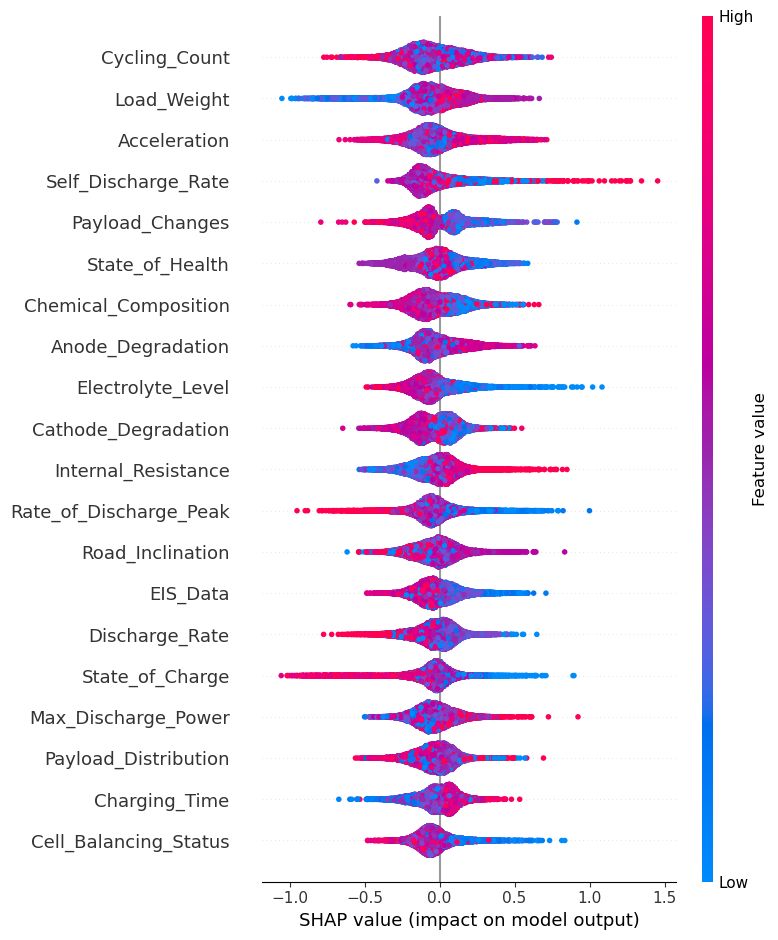

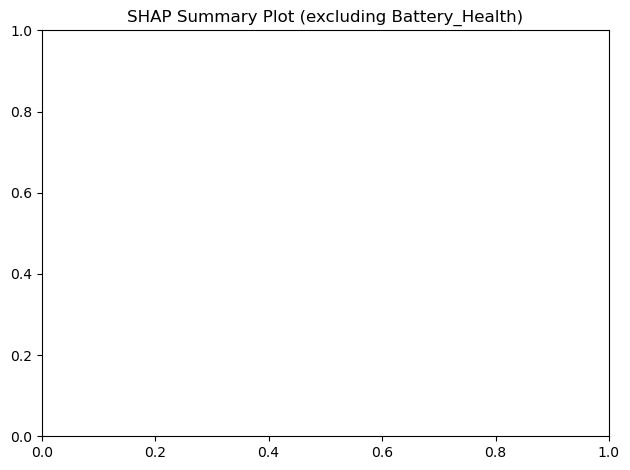

In [55]:
# --- SHAP Analysis (Visualizing features other than Battery_Health) ---
print("\n--- SHAP Analysis (for XGBoost as an example) ---")
# Initialize the SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(model_xgb)

# Calculate SHAP values on the test set
shap_values = explainer.shap_values(X_test)

# Check the shape of shap_values
print(f"The shape of shap_values is: {np.array(shap_values).shape}")

if isinstance(shap_values, list):
    print(f"Shape of SHAP values for class 0: {shap_values[0].shape}")
    print(f"Shape of SHAP values for class 1: {shap_values[1].shape}")

# Get feature names, excluding 'Battery_Health' for visualization
feature_names = [col for col in X_train.columns if col != 'Battery_Health']
feature_names_all = X_train.columns # Keep all feature names for force plot

# Get indices of features excluding 'Battery_Health'
feature_indices_to_visualize = [i for i, col in enumerate(X_train.columns) if col != 'Battery_Health']
# Visualize SHAP results

# 1. Summary Plot (excluding 'Battery_Health')
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[:, feature_indices_to_visualize], X_test.iloc[:, feature_indices_to_visualize], feature_names=feature_names)
plt.title("SHAP Summary Plot (excluding Battery_Health)")
plt.tight_layout()
plt.show()



--- Feature Selection based on SHAP Importance ---

Number of features before selection: 53
Number of important features selected: 20
Selected important features (top 20): ['Battery_Health', 'Cycling_Count', 'Load_Weight', 'Acceleration', 'Self_Discharge_Rate', 'Payload_Changes', 'State_of_Health', 'Chemical_Composition', 'Anode_Degradation', 'Electrolyte_Level', 'Cathode_Degradation', 'Internal_Resistance', 'Rate_of_Discharge_Peak', 'Road_Inclination', 'EIS_Data', 'Discharge_Rate', 'Max_Discharge_Power', 'State_of_Charge', 'Payload_Distribution', 'Charging_Time']


C:\Users\spakt\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy after selecting important features: 0.9983
Classification Report after selecting important features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- SHAP Analysis on the Model with Important Features (excluding Battery_Health) ---


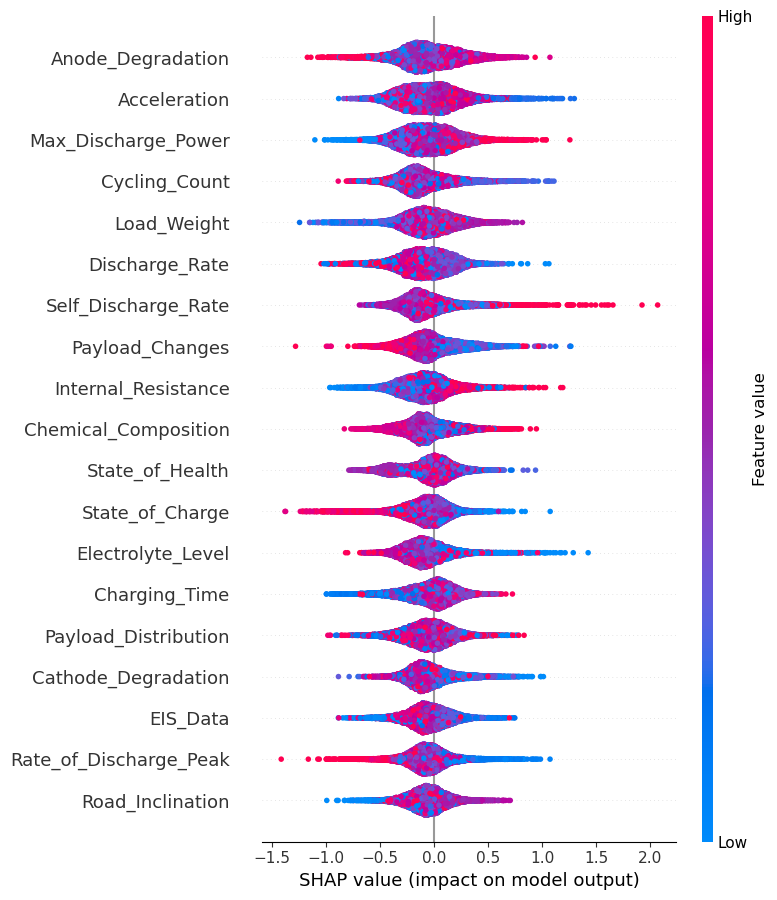

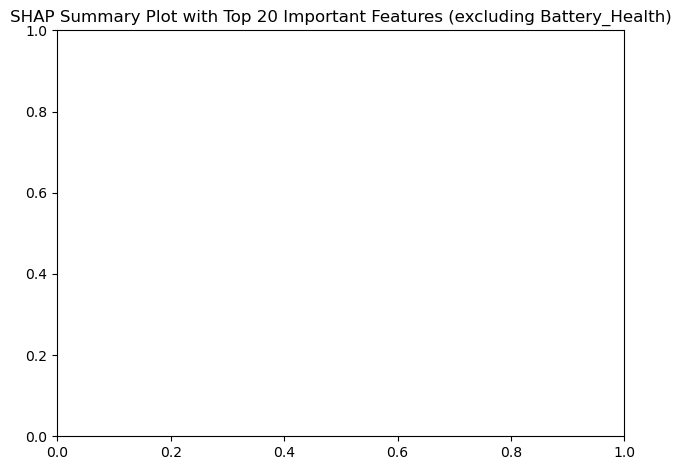

In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have your trained model_xgb, X_train, X_test, y_train, y_test

# --- Feature Selection based on SHAP Importance ---
print("\n--- Feature Selection based on SHAP Importance ---")

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train) # Use training data to determine feature importance

# Get feature importances based on mean absolute SHAP values
feature_importances = np.abs(shap_values).mean(axis=0)

# If shap_values is a list (for multi-class), take the mean across all classes
if isinstance(feature_importances, np.ndarray) and feature_importances.ndim == 2:
    feature_importances = feature_importances.mean(axis=0)

feature_names_all = list(X_train.columns)
importance_df = pd.DataFrame({'Feature': feature_names_all, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Select the top N important features
top_n = 20 # You can adjust this number
important_features_to_keep = importance_df['Feature'].head(top_n).tolist()

# Filter the features in your training and testing data
X_train_important = X_train[[col for col in important_features_to_keep if col in X_train.columns]]
X_test_important = X_test[[col for col in important_features_to_keep if col in X_test.columns]]

print(f"\nNumber of features before selection: {X_train.shape[1]}")
print(f"Number of important features selected: {X_train_important.shape[1]}")
print(f"Selected important features (top {top_n}): {X_train_important.columns.tolist()}")

# Train a new XGBoost model using only the important features
model_xgb_important = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb_important.fit(X_train_important, y_train)

# Make predictions on the test set
y_pred_important = model_xgb_important.predict(X_test_important)

# Evaluate the model
accuracy_important = accuracy_score(y_test, y_pred_important)
print(f"\nAccuracy after selecting important features: {accuracy_important:.4f}")
print("Classification Report after selecting important features:")
print(classification_report(y_test, y_pred_important))

# --- SHAP Analysis on the Model with Important Features (excluding Battery_Health) ---
print("\n--- SHAP Analysis on the Model with Important Features (excluding Battery_Health) ---")

explainer_important = shap.TreeExplainer(model_xgb_important)
shap_values_important_all = explainer_important.shap_values(X_test_important)
feature_names_important_all = list(X_test_important.columns)

# Filter out 'Battery_Health' if it's in the selected features
if 'Battery_Health' in feature_names_important_all:
    battery_health_index = feature_names_important_all.index('Battery_Health')
    if isinstance(shap_values_important_all, list):
        shap_values_important = [vals[:, [i for i in range(vals.shape[1]) if i != battery_health_index]] for vals in shap_values_important_all]
    else:
        shap_values_important = shap_values_important_all[:, [i for i in range(shap_values_important_all.shape[1]) if i != battery_health_index]]
    feature_names_important = [f for f in feature_names_important_all if f != 'Battery_Health']
else:
    shap_values_important = shap_values_important_all
    feature_names_important = feature_names_important_all

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_important, pd.DataFrame(X_test_important, columns=feature_names_important_all)[[col for col in feature_names_important_all if col != 'Battery_Health']], feature_names=feature_names_important)
plt.title(f"SHAP Summary Plot with Top {top_n} Important Features (excluding Battery_Health)")
plt.tight_layout()
plt.show()

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have your trained model_xgb, X_train, X_test, y_train, y_test

# --- Feature Selection based on SHAP Importance ---
print("\n--- Feature Selection based on SHAP Importance ---")

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train) # Use training data to determine feature importance

# Get feature importances based on mean absolute SHAP values
feature_importances = np.abs(shap_values).mean(axis=0)

# If shap_values is a list (for multi-class), take the mean across all classes
if isinstance(feature_importances, np.ndarray) and feature_importances.ndim == 2:
    feature_importances = feature_importances.mean(axis=0)

feature_names_all = list(X_train.columns)
importance_df = pd.DataFrame({'Feature': feature_names_all, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Select the top N important features
top_n = 20 # You can adjust this number
important_features_to_keep = importance_df['Feature'].head(top_n).tolist()

# Filter the features in your training and testing data
X_train_important = X_train[[col for col in important_features_to_keep if col in X_train.columns]]
X_test_important = X_test[[col for col in important_features_to_keep if col in X_test.columns]]

print(f"\nNumber of features before selection: {X_train.shape[1]}")
print(f"Number of important features selected: {X_train_important.shape[1]}")
print(f"Selected important features (top {top_n}): {X_train_important.columns.tolist()}")

# Train a new XGBoost model using only the important features
model_xgb_important = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb_important.fit(X_train_important, y_train)

# Make predictions on the test set
y_pred_important = model_xgb_important.predict(X_test_important)

# Evaluate the model
accuracy_important = accuracy_score(y_test, y_pred_important)
print(f"\nAccuracy after selecting important features: {accuracy_important:.4f}")
print("Classification Report after selecting important features:")
print(classification_report(y_test, y_pred_important))

# --- SHAP Analysis on the Model with Important Features (excluding Battery_Health) ---
print("\n--- SHAP Analysis on the Model with Important Features (excluding Battery_Health) ---")

explainer_important = shap.TreeExplainer(model_xgb_important)
shap_values_important_all = explainer_important.shap_values(X_test_important)
feature_names_important_all = list(X_test_important.columns)

# Filter out 'Battery_Health' if it's in the selected features
if 'Battery_Health' in feature_names_important_all:
    battery_health_index = feature_names_important_all.index('Battery_Health')
    if isinstance(shap_values_important_all, list):
        shap_values_important = [vals[:, [i for i in range(vals.shape[1]) if i != battery_health_index]] for vals in shap_values_important_all]
    else:
        shap_values_important = shap_values_important_all[:, [i for i in range(shap_values_important_all.shape[1]) if i != battery_health_index]]
    feature_names_important = [f for f in feature_names_important_all if f != 'Battery_Health']
else:
    shap_values_important = shap_values_important_all
    feature_names_important = feature_names_important_all

plt.figure(figsize=(10, 8))


--- Feature Selection based on SHAP Importance ---

Number of features before selection: 53
Number of important features selected: 20
Selected important features (top 20): ['Battery_Health', 'Cycling_Count', 'Load_Weight', 'Acceleration', 'Self_Discharge_Rate', 'Payload_Changes', 'State_of_Health', 'Chemical_Composition', 'Anode_Degradation', 'Electrolyte_Level', 'Cathode_Degradation', 'Internal_Resistance', 'Rate_of_Discharge_Peak', 'Road_Inclination', 'EIS_Data', 'Discharge_Rate', 'Max_Discharge_Power', 'State_of_Charge', 'Payload_Distribution', 'Charging_Time']


C:\Users\spakt\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:16:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy after selecting important features: 0.9983
Classification Report after selecting important features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- SHAP Analysis on the Model with Important Features (excluding Battery_Health) ---


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [21]:
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you have your trained model_xgb, X_train, X_test, y_train, y_test

# --- Feature Selection based on SHAP Importance ---
print("\n--- Feature Selection based on SHAP Importance ---")

# Initialize SHAP explainer
# Using the original model_xgb to determine overall feature importance
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train) # Use training data to determine feature importance

# Get feature importances based on mean absolute SHAP values
feature_importances = np.abs(shap_values).mean(axis=0)

# If shap_values is a list (for multi-class), take the mean across all classes
if isinstance(feature_importances, np.ndarray) and feature_importances.ndim == 2:
    feature_importances = feature_importances.mean(axis=0)

feature_names_all = list(X_train.columns)
importance_df = pd.DataFrame({'Feature': feature_names_all, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Select the top N important features
top_n = 20 # You can adjust this number
important_features_to_keep = importance_df['Feature'].head(top_n).tolist()

# Filter the features in your training and testing data based on importance
X_train_important = X_train[[col for col in important_features_to_keep if col in X_train.columns]]
X_test_important = X_test[[col for col in important_features_to_keep if col in X_test.columns]]

print(f"\nNumber of features before selection: {X_train.shape[1]}")
print(f"Number of important features selected: {X_train_important.shape[1]}")
print(f"Selected important features (top {top_n}): {X_train_important.columns.tolist()}")

# You can optionally train the XGBoost model with selected features here if you want to evaluate it
# print("\n--- XGBoost Model (with selected features) ---")
# model_xgb_important = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
# model_xgb_important.fit(X_train_important, y_train)
# y_pred_important_xgb = model_xgb_important.predict(X_test_important)
# accuracy_important_xgb = accuracy_score(y_test, y_pred_important_xgb)
# print(f"Accuracy: {accuracy_important_xgb:.4f}")
# print(classification_report(y_test, y_pred_important_xgb))


# --- Implement other Ensemble Models with Selected Features ---

print("\n--- Random Forest Model (with selected features) ---")
model_rf_important = RandomForestClassifier(random_state=42) # Using default parameters for simplicity
model_rf_important.fit(X_train_important, y_train)
y_pred_rf_important = model_rf_important.predict(X_test_important)
accuracy_rf_important = accuracy_score(y_test, y_pred_rf_important)
print(f"Accuracy: {accuracy_rf_important:.4f}")
print(classification_report(y_test, y_pred_rf_important))

print("\n--- AdaBoost Model (with selected features) ---")
model_ada_important = AdaBoostClassifier(random_state=42) # Using default parameters for simplicity
model_ada_important.fit(X_train_important, y_train)
y_pred_ada_important = model_ada_important.predict(X_test_important)
accuracy_ada_important = accuracy_score(y_test, y_pred_ada_important)
print(f"Accuracy: {accuracy_ada_important:.4f}")
print(classification_report(y_test, y_pred_ada_important))

print("\n--- Gradient Boosting Model (with selected features) ---")
model_gb_important = GradientBoostingClassifier(random_state=42) # Using default parameters for simplicity
model_gb_important.fit(X_train_important, y_train)
y_pred_gb_important = model_gb_important.predict(X_test_important)
accuracy_gb_important = accuracy_score(y_test, y_pred_gb_important)
print(f"Accuracy: {accuracy_gb_important:.4f}")
print(classification_report(y_test, y_pred_gb_important))

print("\n--- Bagging Model (with selected features) ---")
model_bag_important = BaggingClassifier(random_state=42) # Using default parameters for simplicity
model_bag_important.fit(X_train_important, y_train)
y_pred_bag_important = model_bag_important.predict(X_test_important)
accuracy_bag_important = accuracy_score(y_test, y_pred_bag_important)
print(f"Accuracy: {accuracy_bag_important:.4f}")
print(classification_report(y_test, y_pred_bag_important))

print("\n--- Stacking Classifier (with selected features) ---")
# Using default base estimators and final estimator for simplicity
estimators_important = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
]
final_estimator_important = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for potential convergence
model_stacking_important = StackingClassifier(estimators=estimators_important, final_estimator=final_estimator_important, cv=5)
model_stacking_important.fit(X_train_important, y_train)
y_pred_stacking_important = model_stacking_important.predict(X_test_important)
accuracy_stacking_important = accuracy_score(y_test, y_pred_stacking_important)
print(f"Accuracy: {accuracy_stacking_important:.4f}")
print(classification_report(y_test, y_pred_stacking_important))

print("\n--- Voting Classifier (with selected features) ---")
# Using default base estimators for simplicity
clf1_important = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for potential convergence
clf2_important = RandomForestClassifier(random_state=42)
clf3_important = GradientBoostingClassifier(random_state=42)
model_voting_important = VotingClassifier(estimators=[('lr', clf1_important), ('rf', clf2_important), ('gb', clf3_important)], voting='hard')
model_voting_important.fit(X_train_important, y_train)
y_pred_voting_important = model_voting_important.predict(X_test_important)
accuracy_voting_important = accuracy_score(y_test, y_pred_voting_important)
print(f"Accuracy: {accuracy_voting_important:.4f}")
print(classification_report(y_test, y_pred_voting_important))

print("\n--- CatBoost Model (with selected features) ---")
model_cat_important = CatBoostClassifier(verbose=0, random_state=42) # Using default parameters
model_cat_important.fit(X_train_important, y_train)
y_pred_cat_important = model_cat_important.predict(X_test_important)
accuracy_cat_important = accuracy_score(y_test, y_pred_cat_important)
print(f"Accuracy: {accuracy_cat_important:.4f}")
print(classification_report(y_test, y_pred_cat_important))

print("\n--- LogitBoost Model (with selected features) ---")
model_logit_important = AdaBoostClassifier(algorithm='SAMME', random_state=42) # Using default parameters
model_logit_important.fit(X_train_important, y_train)
y_pred_logit_important = model_logit_important.predict(X_test_important)
accuracy_logit_important = accuracy_score(y_test, y_pred_logit_important)
print(f"Accuracy: {accuracy_logit_important:.4f}")
print(classification_report(y_test, y_pred_logit_important))

print("\n--- Extra Trees Model (with selected features) ---")
model_et_important = ExtraTreesClassifier(random_state=42) # Using default parameters
model_et_important.fit(X_train_important, y_train)
y_pred_et_important = model_et_important.predict(X_test_important)
accuracy_et_important = accuracy_score(y_test, y_pred_et_important)
print(f"Accuracy: {accuracy_et_important:.4f}")
print(classification_report(y_test, y_pred_et_important))

# Note: The SHAP analysis and plot for the model with important features are in a separate block above if you need them again.


--- Feature Selection based on SHAP Importance ---

Number of features before selection: 53
Number of important features selected: 20
Selected important features (top 20): ['Battery_Health', 'Cycling_Count', 'Load_Weight', 'Acceleration', 'Self_Discharge_Rate', 'Payload_Changes', 'State_of_Health', 'Chemical_Composition', 'Anode_Degradation', 'Electrolyte_Level', 'Cathode_Degradation', 'Internal_Resistance', 'Rate_of_Discharge_Peak', 'Road_Inclination', 'EIS_Data', 'Discharge_Rate', 'Max_Discharge_Power', 'State_of_Charge', 'Payload_Distribution', 'Charging_Time']

--- Random Forest Model (with selected features) ---
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- AdaBoost Model (with sele

C:\Users\spakt\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- Gradient Boosting Model (with selected features) ---
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- Bagging Model (with selected features) ---
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy             

C:\Users\spakt\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- CatBoost Model (with selected features) ---
Accuracy: 0.9996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


--- LogitBoost Model (with selected features) ---
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11065
           1       1.00      1.00      1.00      8935

    accuracy                   

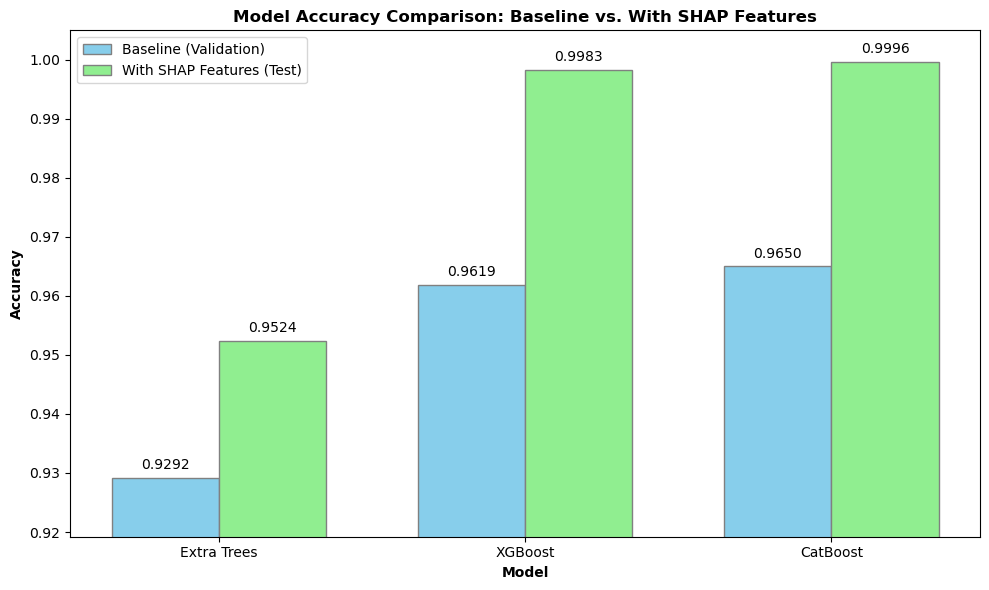

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
model_names = ['Extra Trees', 'XGBoost', 'CatBoost']

# Accuracies
baseline_accuracies = np.array([0.9292, 0.9619, 0.9650]) # Validation accuracies without SHAP selection
shap_features_accuracies = np.array([0.9524, 0.9983, 0.9996]) # Test accuracies with SHAP features

# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
plt.bar(r1, baseline_accuracies, color='skyblue', width=bar_width, edgecolor='grey', label='Baseline (Validation)')
plt.bar(r2, shap_features_accuracies, color='lightgreen', width=bar_width, edgecolor='grey', label='With SHAP Features (Test)')

# Add labels and title
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Model Accuracy Comparison: Baseline vs. With SHAP Features', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(model_names))], model_names)

# Add accuracy values on top of the bars
for i in range(len(model_names)):
    plt.text(r1[i], baseline_accuracies[i] + 0.001, f'{baseline_accuracies[i]:.4f}', ha='center', va='bottom')
    plt.text(r2[i], shap_features_accuracies[i] + 0.001, f'{shap_features_accuracies[i]:.4f}', ha='center', va='bottom')

# Set y-axis limits for better visualization of differences
# Increased the upper limit slightly
plt.ylim(min(baseline_accuracies.min(), shap_features_accuracies.min()) - 0.01, 1.005) # Adjusted upper limit


# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [129]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
# Assuming y_pred_cat_tuned, y_pred_xgb_tuned, y_pred_et_tuned, and y_val are available
# from the previous code execution where these models were evaluated on X_val.

print("\n--- Detailed Performance Metrics (Validation Set) ---")

# List of model prediction results and their names
model_predictions = [
    (y_pred_cat_tuned, 'CatBoost'),
    (y_pred_xgb_tuned, 'XGBoost'),
    (y_pred_et_tuned, 'Extra Trees')
]

for y_pred, name in model_predictions:
    print(f"\n--- Metrics for {name} ---")

    # Calculate Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    # Extract components: cm[true_label, predicted_label]
    # Use the .ravel() method which works reliably for 2x2 matrices
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        # Handle cases where only one class was predicted (unlikely with high accuracy)
        # But for safety, extract based on shape
        if cm.shape == (2, 2):
             tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
        else:
             print("Warning: Confusion matrix is not 2x2. Cannot calculate all metrics.")
             print(cm)
             continue # Skip to the next model


    # Calculate other metrics from Confusion Matrix components

    # Precision for Class 0 (Negative Predictive Value for Predicted Class 0)
    precision_0 = precision_score(y_val, y_pred, pos_label=0)
    print(f"Precision (Class 0 / Pred Negative PPV): {precision_0:.4f}")

    # Recall for Class 0 (True Negative Rate - TNR)
    recall_0 = recall_score(y_val, y_pred, pos_label=0)
    print(f"Recall (Class 0 / TNR): {recall_0:.4f}")

    # Precision for Class 1 (Positive Predictive Value - PPV)
    precision_1 = precision_score(y_val, y_pred, pos_label=1)
    print(f"Precision (Class 1 / PPV): {precision_1:.4f}")

    # Recall for Class 1 (Sensitivity / True Positive Rate - TPR)
    recall_1 = recall_score(y_val, y_pred, pos_label=1)
    print(f"Recall (Class 1 / Sensitivity / TPR): {recall_1:.4f}")


    # False Positive Rate (FPR) - Rate of predicting positive when actual is negative
    # FPR = FP / (FP + TN)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    print(f"False Positive Rate (FPR): {fpr:.4f}")

    # False Negative Rate (FNR) - Rate of predicting negative when actual is positive
    # FNR = FN / (FN + TP)
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    print(f"False Negative Rate (FNR): {fnr:.4f}")

    # Negative Predictive Value (NPV) - Proportion of correctly predicted negatives out of all predicted negatives
    # NPV = TN / (TN + FN)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    print(f"Negative Predictive Value (NPV): {npv:.4f}")


    print("-" * 30) # Separator for clarity

print("\nDetailed metrics calculation complete for validation set.")


--- Detailed Performance Metrics (Validation Set) ---

--- Metrics for CatBoost ---
Accuracy: 0.9650
Precision (Class 0 / Pred Negative PPV): 0.9410
Recall (Class 0 / TNR): 1.0000
Precision (Class 1 / PPV): 1.0000
Recall (Class 1 / Sensitivity / TPR): 0.9208
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.0792
Negative Predictive Value (NPV): 0.9410
------------------------------

--- Metrics for XGBoost ---
Accuracy: 0.9619
Precision (Class 0 / Pred Negative PPV): 0.9360
Recall (Class 0 / TNR): 1.0000
Precision (Class 1 / PPV): 1.0000
Recall (Class 1 / Sensitivity / TPR): 0.9138
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.0862
Negative Predictive Value (NPV): 0.9360
------------------------------

--- Metrics for Extra Trees ---
Accuracy: 0.9292
Precision (Class 0 / Pred Negative PPV): 0.8889
Recall (Class 0 / TNR): 0.9978
Precision (Class 1 / PPV): 0.9967
Recall (Class 1 / Sensitivity / TPR): 0.8426
False Positive Rate (FPR): 0.0022
False Negative R

In [23]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming X_train_important, X_test_important, y_train, and y_test are already defined
# and the models (model_rf_important, model_ada_important, etc.) have been trained
# using the selected features (X_train_important) as in the previous code block.

# --- Function to print detailed metrics ---
def print_detailed_metrics(y_true, y_pred, model_name):
    """
    Calculates and prints detailed classification metrics for a binary classification model.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        model_name (str): Name of the model for printing.
    """
    print(f"\n--- Metrics for {model_name} ---")
    accuracy = accuracy_score(y_true, y_pred)

    # Use output_dict=True to get metrics as a dictionary
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    # Added zero_division=0 to handle cases where a class has no true samples or no predicted samples

    # Assuming binary classification (Class 0 and Class 1)
    # Extract metrics from the report dictionary
    # Handle potential missing keys if a class is completely absent in predictions/true labels
    precision_0 = report['0'].get('precision', 0.0)
    recall_0 = report['0'].get('recall', 0.0) # TNR
    precision_1 = report['1'].get('precision', 0.0) # PPV
    recall_1 = report['1'].get('recall', 0.0) # Sensitivity / TPR

    # Calculate additional metrics
    # FPR = 1 - TNR (Recall for Class 0)
    fpr = 1 - recall_0
    # FNR = 1 - TPR (Recall for Class 1)
    fnr = 1 - recall_1
    # NPV = Precision (Class 0)
    npv = precision_0

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Class 0 / Pred Negative PPV): {precision_0:.4f}")
    print(f"Recall (Class 0 / TNR): {recall_0:.4f}")
    print(f"Precision (Class 1 / PPV): {precision_1:.4f}")
    print(f"Recall (Class 1 / Sensitivity / TPR): {recall_1:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"Negative Predictive Value (NPV): {npv:.4f}")

# --- Apply Metrics to Each Trained Model ---

# Note: The model training code from the previous step is required
# to generate the 'y_pred' variables used below.
# Ensure the following models have been trained using X_train_important
# and predictions made on X_test_important:
# model_rf_important, model_ada_important, model_gb_important,
# model_bag_important, model_stacking_important, model_voting_important,
# model_cat_important, model_logit_important, model_et_important

# Example usage (assuming y_pred variables are available):

print_detailed_metrics(y_test, y_pred_rf_important, "Random Forest Model (with selected features)")
print_detailed_metrics(y_test, y_pred_ada_important, "AdaBoost Model (with selected features)")
print_detailed_metrics(y_test, y_pred_gb_important, "Gradient Boosting Model (with selected features)")
print_detailed_metrics(y_test, y_pred_bag_important, "Bagging Model (with selected features)")
print_detailed_metrics(y_test, y_pred_stacking_important, "Stacking Classifier (with selected features)")
print_detailed_metrics(y_test, y_pred_voting_important, "Voting Classifier (with selected features)")
print_detailed_metrics(y_test, y_pred_cat_important, "CatBoost Model (with selected features)")
print_detailed_metrics(y_test, y_pred_logit_important, "LogitBoost Model (with selected features)")
print_detailed_metrics(y_test, y_pred_et_important, "Extra Trees Model (with selected features)")


--- Metrics for Random Forest Model (with selected features) ---
Accuracy: 1.0000
Precision (Class 0 / Pred Negative PPV): 1.0000
Recall (Class 0 / TNR): 1.0000
Precision (Class 1 / PPV): 1.0000
Recall (Class 1 / Sensitivity / TPR): 1.0000
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.0000
Negative Predictive Value (NPV): 1.0000

--- Metrics for AdaBoost Model (with selected features) ---
Accuracy: 1.0000
Precision (Class 0 / Pred Negative PPV): 1.0000
Recall (Class 0 / TNR): 1.0000
Precision (Class 1 / PPV): 1.0000
Recall (Class 1 / Sensitivity / TPR): 1.0000
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.0000
Negative Predictive Value (NPV): 1.0000

--- Metrics for Gradient Boosting Model (with selected features) ---
Accuracy: 1.0000
Precision (Class 0 / Pred Negative PPV): 1.0000
Recall (Class 0 / TNR): 1.0000
Precision (Class 1 / PPV): 1.0000
Recall (Class 1 / Sensitivity / TPR): 1.0000
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0

In [27]:
print_detailed_metrics(y_test, y_pred_important, "XGBoost Model (with selected features)")


--- Metrics for XGBoost Model (with selected features) ---
Accuracy: 0.9983
Precision (Class 0 / Pred Negative PPV): 0.9983
Recall (Class 0 / TNR): 0.9986
Precision (Class 1 / PPV): 0.9983
Recall (Class 1 / Sensitivity / TPR): 0.9979
False Positive Rate (FPR): 0.0014
False Negative Rate (FNR): 0.0021
Negative Predictive Value (NPV): 0.9983
